In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import spacy
from collections import Counter
%matplotlib inline
sns.set_style("darkgrid")
colors = ['#651FFF', '#00B0FF', '#1DE9B6', '#00E676', '#FF9100', '#FF3D00']
sns.set_palette(colors)

## Introduction

For this exercise we'll be using New York City bus data from October 2017. The data was pulled from Kaggle at <> LINK <>. The data tracks the location of each bus, it's next stop, as well as it's expected arrival time and scheduled arrival time.

From the expected arrival time and the scheduled arrival time we will determine how far on or off of schedule a bus is. The city of New York defines a bus as on time if it is less than one minute early and less than 5 minutes late. So we will use those guidelines to create a binary variable, and use the other columns to create features that we will predict if a bus will be on time or not.

In [2]:
bus = pd.read_csv('data/mta_1710.csv', low_memory=False, usecols=['RecordedAtTime','DirectionRef','PublishedLineName','OriginName','OriginLat','OriginLong','DestinationName','DestinationLat','DestinationLong','VehicleRef','VehicleLocation.Latitude','VehicleLocation.Longitude',
                                                          'NextStopPointName','ArrivalProximityText','DistanceFromStop','ExpectedArrivalTime','ScheduledArrivalTime'])
# let's take a quick look at the data
bus.head()

RecordedAtTime  DirectionRef PublishedLineName             OriginName  \
0  2017-10-01 00:03:31             0           M60-SBS      BROADWAY/W 106 ST   
1  2017-10-01 00:03:32             0               Q58  PALMETTO ST/MYRTLE AV   
2  2017-10-01 00:03:29             0               M15  SOUTH ST/WHITEHALL ST   
3  2017-10-01 00:03:24             1               S78    ST GEORGE FERRY/S78   
4  2017-10-01 00:03:22             0                B6    HARWAY AV/BAY 37 ST   

   OriginLat  OriginLong                        DestinationName  \
0  40.801818  -73.967642  SELECT BUS SERVICE LA GUARDIA AIRPORT   
1  40.700178  -73.910254                       FLUSHING MAIN ST   
2  40.701536  -74.012485            EAST HARLEM 125 ST via 1 AV   
3  40.643655  -74.073470                         BRICKTOWN MALL   
4  40.593510  -73.993996                   EAST NY NEW LOTS STA   

   DestinationLat  DestinationLong VehicleRef  VehicleLocation.Latitude  \
0       40.768074       -73.862089  NYCT_5846                 40.809715   
1       40.757344       -73.829362  NYCT_3967                 40.742271   
2       40.803150       -73.932264  NYCT_5912                 40.770211   
3       40.530061       -74.226654  NYCT_8180                 40.643197   
4       40.666420       -73.883387  NYCT_5110                 40.633909   

   VehicleLocation.Longitude       NextStopPointName ArrivalProximityText  \
0                 -73.960110   AMSTERDAM AV/W 120 ST          approaching   
1                 -73.854411          108 ST/OTIS AV          approaching   
2                 -73.954244            1 AV/E 77 ST          approaching   
3                 -74.074438  BAY ST/NICK LAPORTE PL        < 1 stop away   
4                 -73.918793   FLATLANDS AV/RALPH AV        < 1 stop away   

  DistanceFromStop  ExpectedArrivalTime ScheduledArrivalTime  
0              122  2017-10-01 00:04:06             24:05:28  
1              131  2017-10-01 00:04:03             23:33:09  
2              135  2017-10-01 00:04:03             23:51:06  
3              205  2017-10-01 00:03:55             24:00:44  
4              271  2017-10-01 00:04:21             23:47:00

#### Shape of Data
There are about 7 million rows here, which ultimately will be too much to work with, so we'll have to sample part of this a bit later on.

In [3]:
bus.shape

(6865841, 17)

#### Datatypes
A lot of these are text based / objects so we will also have to create some numeric features out of these as well.

In [4]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865841 entries, 0 to 6865840
Data columns (total 17 columns):
RecordedAtTime               object
DirectionRef                 int64
PublishedLineName            object
OriginName                   object
OriginLat                    float64
OriginLong                   float64
DestinationName              object
DestinationLat               float64
DestinationLong              float64
VehicleRef                   object
VehicleLocation.Latitude     float64
VehicleLocation.Longitude    float64
NextStopPointName            object
ArrivalProximityText         object
DistanceFromStop             object
ExpectedArrivalTime          object
ScheduledArrivalTime         object
dtypes: float64(6), int64(1), object(10)
memory usage: 890.5+ MB


#### Null Values
There are a lot of null values in the expected arrival time but because it is a variable we need to create delay time, dropping them will be neccessary. The rest of the null numbers will affect the data pretty inconsequentially.

In [5]:
# Check the null values and put into dataframe for readability. 
nullvals = pd.DataFrame(bus.isna().sum())
nullvals

0
RecordedAtTime                   0
DirectionRef                     0
PublishedLineName                0
OriginName                   63445
OriginLat                    63445
OriginLong                   63445
DestinationName                  0
DestinationLat               10369
DestinationLong              10369
VehicleRef                       0
VehicleLocation.Latitude         0
VehicleLocation.Longitude        0
NextStopPointName             7086
ArrivalProximityText          7086
DistanceFromStop              7086
ExpectedArrivalTime        1101889
ScheduledArrivalTime        151912

In [6]:
bus = bus.dropna()

In [7]:
bus.shape

(5715166, 17)

#### Create the Outcome Variable
Here we want to convert everything that is a date into a datetime format so we can split it up and create our delay feature. Also will pull some features / information out of the recorded at time column, such as a column for date / time recorded.

In [8]:
bus['RecordedAtDateTime'] = pd.to_datetime(bus['RecordedAtTime'])

In [9]:
bus['day_of_week'] = bus['RecordedAtDateTime'].dt.dayofweek

In [10]:
bus['RecordedAtTime'] = bus['RecordedAtDateTime'].dt.time

In [11]:
bus['date'] = bus['RecordedAtDateTime'].dt.date

In [12]:
bus.head(2)

RecordedAtTime  DirectionRef PublishedLineName             OriginName  \
0       00:03:31             0           M60-SBS      BROADWAY/W 106 ST   
1       00:03:32             0               Q58  PALMETTO ST/MYRTLE AV   

   OriginLat  OriginLong                        DestinationName  \
0  40.801818  -73.967642  SELECT BUS SERVICE LA GUARDIA AIRPORT   
1  40.700178  -73.910254                       FLUSHING MAIN ST   

   DestinationLat  DestinationLong VehicleRef  VehicleLocation.Latitude  \
0       40.768074       -73.862089  NYCT_5846                 40.809715   
1       40.757344       -73.829362  NYCT_3967                 40.742271   

   VehicleLocation.Longitude      NextStopPointName ArrivalProximityText  \
0                 -73.960110  AMSTERDAM AV/W 120 ST          approaching   
1                 -73.854411         108 ST/OTIS AV          approaching   

  DistanceFromStop  ExpectedArrivalTime ScheduledArrivalTime  \
0              122  2017-10-01 00:04:06             24:05:28   
1              131  2017-10-01 00:04:03             23:33:09   

   RecordedAtDateTime  day_of_week        date  
0 2017-10-01 00:03:31            6  2017-10-01  
1 2017-10-01 00:03:32            6  2017-10-01

In [13]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5715166 entries, 0 to 6865840
Data columns (total 20 columns):
RecordedAtTime               object
DirectionRef                 int64
PublishedLineName            object
OriginName                   object
OriginLat                    float64
OriginLong                   float64
DestinationName              object
DestinationLat               float64
DestinationLong              float64
VehicleRef                   object
VehicleLocation.Latitude     float64
VehicleLocation.Longitude    float64
NextStopPointName            object
ArrivalProximityText         object
DistanceFromStop             object
ExpectedArrivalTime          object
ScheduledArrivalTime         object
RecordedAtDateTime           datetime64[ns]
day_of_week                  int64
date                         object
dtypes: datetime64[ns](1), float64(6), int64(2), object(11)
memory usage: 915.7+ MB


#### Calculating the delays
Here we separate out each of the elements of the datetime to create a delay variable. Because it's time we are dealing with and not actual numbers we will have to create it a little bit unconventionally.

In [14]:
# DONT RUN THIS TWICE, WILL BREAK THE TIME
bus['ExpectedArrivalTime'] = pd.to_datetime(bus['ExpectedArrivalTime'], errors='coerce', utc=True)
bus['ExpectedArrivalTime'].head()

bus['ExpectedArrivalTime'] = pd.to_datetime(bus['ExpectedArrivalTime'], errors='coerce', utc=True)
sch_hours = pd.DataFrame()
sch_hours['hour'] = bus['ExpectedArrivalTime'].dt.hour
sch_hours['min'] = bus['ExpectedArrivalTime'].dt.minute

sch_hours['time'] = sch_hours['hour'].astype(str).str.cat(sch_hours['min'].astype(str))
sch_hours['time'] = sch_hours['time'].str.replace('.0','')
sch_hours['time'] = pd.to_numeric(sch_hours['time'], errors='coerce')

In [15]:
bus['ExpectedArrivalTime'] = sch_hours['time']

In [16]:
# DONT RUN THIS TWICE, WILL BREAK THE TIME
bus['ScheduledArrivalTime'] = pd.to_datetime(bus['ScheduledArrivalTime'], errors='coerce', utc=True)
sch_hours2 = pd.DataFrame()
sch_hours2['hour'] = bus['ScheduledArrivalTime'].dt.hour
sch_hours2['min'] = bus['ScheduledArrivalTime'].dt.minute

sch_hours2['time'] = sch_hours2['hour'].astype(str).str.cat(sch_hours2['min'].astype(str))
sch_hours2['time'] = sch_hours2['time'].str.replace('.0','')
sch_hours2['time'] = pd.to_numeric(sch_hours2['time'], errors='coerce')

In [17]:
bus['ScheduledArrivalTime'] = sch_hours2['time']

In [18]:
# DONT RUN THIS TWICE, WILL BREAK THE TIME
rec_hours = pd.DataFrame()
rec_hours['hour'] = bus['RecordedAtDateTime'].dt.hour
rec_hours['min'] = bus['RecordedAtDateTime'].dt.minute

rec_hours['time'] = rec_hours['hour'].astype(str).str.cat(rec_hours['min'].astype(str))
rec_hours['time'] = rec_hours['time'].str.replace('.0','')
rec_hours['time'] = pd.to_numeric(rec_hours['time'], errors='coerce')

In [19]:
bus['RecordedAtTime'] = rec_hours['time']

So we have the scheduled and arrival time worked out here, but as you'll see below the situaltions where a bus has a scheduled time of before midnight but then a expected arrival time of just after midnight

In [20]:
bus[['RecordedAtDateTime','RecordedAtTime','ScheduledArrivalTime','ExpectedArrivalTime']].tail(10)

RecordedAtDateTime  RecordedAtTime  ScheduledArrivalTime  \
6865831 2017-10-31 23:58:58          2358.0                2349.0   
6865832 2017-10-31 23:58:49          2358.0                2359.0   
6865833 2017-10-31 23:58:44          2358.0                2355.0   
6865834 2017-10-31 23:58:37          2358.0                2354.0   
6865835 2017-10-31 23:58:41          2358.0                2341.0   
6865836 2017-10-31 23:58:47          2358.0                2349.0   
6865837 2017-10-31 23:58:30          2358.0                2359.0   
6865838 2017-10-31 23:58:49          2358.0                   NaN   
6865839 2017-10-31 23:58:30          2358.0                2343.0   
6865840 2017-10-31 23:58:44          2358.0                   NaN   

         ExpectedArrivalTime  
6865831               2359.0  
6865832               2359.0  
6865833               2359.0  
6865834               2358.0  
6865835               2358.0  
6865836                  2.0  
6865837                  2.0  
6865838               2359.0  
6865839               2359.0  
6865840               2359.0

In [21]:
bus = bus.dropna()
bus['delay'] = bus['ScheduledArrivalTime'] - bus['ExpectedArrivalTime']

bus[['ScheduledArrivalTime', 'ExpectedArrivalTime', 'delay']].head(10)

ScheduledArrivalTime  ExpectedArrivalTime   delay
1                 2333.0                  4.0  2329.0
2                 2351.0                  4.0  2347.0
4                 2347.0                  4.0  2343.0
6                 2334.0                  4.0  2330.0
9                 2353.0                  4.0  2349.0
11                2336.0                  3.0  2333.0
13                2359.0                  4.0  2355.0
14                2319.0                  4.0  2315.0
15                2349.0                  3.0  2346.0
16                2346.0                  3.0  2343.0

In [22]:
# Subtract all of the delays greater than two hours by 2360 so as to get them back to a reasonable delay time
bus.delay.loc[bus.delay>120] = 2360 - bus.delay.loc[bus.delay>120]

bus[['ScheduledArrivalTime', 'ExpectedArrivalTime', 'delay']].head(20)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ScheduledArrivalTime  ExpectedArrivalTime  delay
1                 2333.0                  4.0   31.0
2                 2351.0                  4.0   13.0
4                 2347.0                  4.0   17.0
6                 2334.0                  4.0   30.0
9                 2353.0                  4.0   11.0
11                2336.0                  3.0   27.0
13                2359.0                  4.0    5.0
14                2319.0                  4.0   45.0
15                2349.0                  3.0   14.0
16                2346.0                  3.0   17.0
17                2358.0                  4.0    6.0
24                2355.0                  3.0    8.0
26                2359.0                  3.0    4.0
29                2346.0                  4.0   18.0
33                2351.0                  3.0   12.0
34                2355.0                  3.0    8.0
43                2353.0                  3.0   10.0
48                2358.0                  3.0    5.0
49                2354.0                  4.0   10.0
54                2353.0                  3.0   10.0

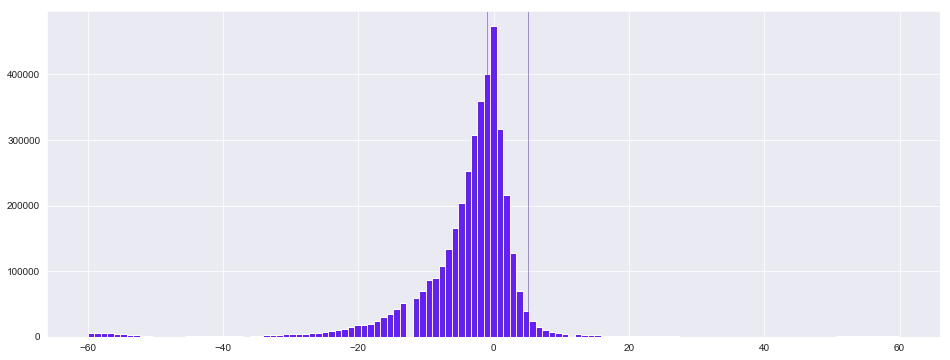

In [23]:
# Take a look at the distribution of the dataset. Lines are there to show what constitutes on-time or not.
bus = bus.drop(bus[bus['delay']>60].index)
bus = bus.drop(bus[bus['delay']<-60].index)
plt.figure(figsize=(16,6))
plt.hist(bus['delay'], bins=125)
plt.axvline(x=5, linewidth=.5)
plt.axvline(x=-1, linewidth=.5)
plt.show()

In [24]:
bus.loc[bus.delay<-10].head()

RecordedAtTime  DirectionRef PublishedLineName  \
1161            13.0             0              M14D   
1162            13.0             0              M14D   
1201            13.0             1               M15   
1584            24.0             1               B60   
1587            24.0             1              Bx27   

                      OriginName  OriginLat  OriginLong  \
1161               11 AV/W 17 ST  40.744841  -74.008147   
1162               11 AV/W 17 ST  40.744841  -74.008147   
1201               E 126 ST/2 AV  40.803230  -73.932451   
1584       WASHINGTON PLZ/LANE 2  40.709517  -73.959497   
1587  MORRISON AV/WESTCHESTER AV  40.829097  -73.874570   

                          DestinationName  DestinationLat  DestinationLong  \
1161  LOWER E. SIDE DELANCY-FDR CROSSTOWN       40.716391       -73.980131   
1162  LOWER E. SIDE DELANCY-FDR CROSSTOWN       40.716391       -73.980131   
1201                 SOUTH FERRY via 2 AV       40.701609       -74.012226   
1584                 CANARSIE WILLIAMS AV       40.650239       -73.891686   
1587                            CLASON PT       40.807544       -73.852337   

     VehicleRef  ...   VehicleLocation.Longitude        NextStopPointName  \
1161  NYCT_5289  ...                  -74.006675          W 18 ST / 10 AV   
1162  NYCT_5289  ...                  -74.006675          W 18 ST / 10 AV   
1201  NYCT_6041  ...                  -73.932604            2 AV/E 125 ST   
1584  NYCT_3993  ...                  -73.939809   JOHNSON AV/BUSHWICK AV   
1587   NYCT_315  ...                  -73.852288  SOUNDVIEW AV/CORNELL AV   

     ArrivalProximityText DistanceFromStop ExpectedArrivalTime  \
1161          approaching               78                13.0   
1162          approaching               78                13.0   
1201        < 1 stop away              169                13.0   
1584          approaching              119                25.0   
1587              at stop                0                24.0   

      ScheduledArrivalTime  RecordedAtDateTime day_of_week        date delay  
1161                   0.0 2017-10-01 00:13:32           6  2017-10-01 -13.0  
1162                   0.0 2017-10-01 00:13:32           6  2017-10-01 -13.0  
1201                   0.0 2017-10-01 00:13:39           6  2017-10-01 -13.0  
1584                   0.0 2017-10-01 00:24:05           6  2017-10-01 -25.0  
1587                  13.0 2017-10-01 00:24:03           6  2017-10-01 -11.0  

[5 rows x 21 columns]

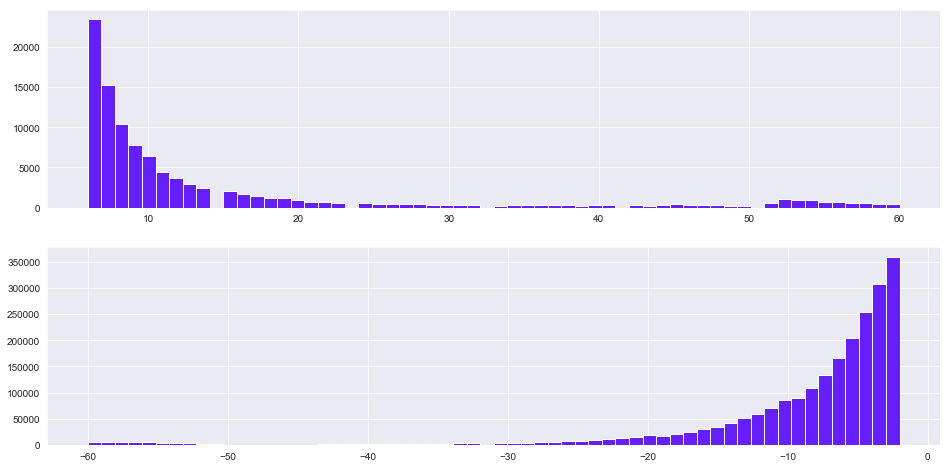

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
bus.delay.loc[bus.delay>5].hist(bins=60)
plt.subplot(2,1,2)
bus.delay.loc[bus.delay<-1].hist(bins=60)
plt.show()

### Create the binary variable
According to this document, an on-time bus is defined as either more than 1 minute early and 5 minutes late: https://docs.google.com/spreadsheets/d/1WqLV3EeCMOZwi0oZdYICkuvN86N0S4QGTMvbhS8UU0E/edit#gid=0. We will use the binary variable here to predict later on.

In [26]:
# https://docs.google.com/spreadsheets/d/1WqLV3EeCMOZwi0oZdYICkuvN86N0S4QGTMvbhS8UU0E/edit#gid=0
bus['on_time'] = np.where((bus['delay'] > 5) | (bus['delay'] < -1), 0, 1)
bus.head(3)

RecordedAtTime  DirectionRef PublishedLineName             OriginName  \
1             3.0             0               Q58  PALMETTO ST/MYRTLE AV   
2             3.0             0               M15  SOUTH ST/WHITEHALL ST   
4             3.0             0                B6    HARWAY AV/BAY 37 ST   

   OriginLat  OriginLong              DestinationName  DestinationLat  \
1  40.700178  -73.910254             FLUSHING MAIN ST       40.757344   
2  40.701536  -74.012485  EAST HARLEM 125 ST via 1 AV       40.803150   
4  40.593510  -73.993996         EAST NY NEW LOTS STA       40.666420   

   DestinationLong VehicleRef   ...        NextStopPointName  \
1       -73.829362  NYCT_3967   ...           108 ST/OTIS AV   
2       -73.932264  NYCT_5912   ...             1 AV/E 77 ST   
4       -73.883387  NYCT_5110   ...    FLATLANDS AV/RALPH AV   

   ArrivalProximityText DistanceFromStop ExpectedArrivalTime  \
1           approaching              131                 4.0   
2           approaching              135                 4.0   
4         < 1 stop away              271                 4.0   

  ScheduledArrivalTime  RecordedAtDateTime  day_of_week        date  delay  \
1               2333.0 2017-10-01 00:03:32            6  2017-10-01   31.0   
2               2351.0 2017-10-01 00:03:29            6  2017-10-01   13.0   
4               2347.0 2017-10-01 00:03:22            6  2017-10-01   17.0   

  on_time  
1       0  
2       0  
4       0  

[3 rows x 22 columns]

## Balance the Data
Looks as if we have more busses that are not on time than we have on-time. To be able to predict accurately, we will blalance these out a bit. It's interesting and somewhat damning for the bus system that more of their busses are not on time than on-time.

In [27]:
compare = pd.DataFrame()

compare['On Time'] = bus.on_time.loc[bus['on_time']==1].describe()
compare['Not On Time'] = bus.on_time.loc[bus['on_time']==0].describe()

compare

On Time  Not On Time
count  1644271.0    2320052.0
mean         1.0          0.0
std          0.0          0.0
min          1.0          0.0
25%          1.0          0.0
50%          1.0          0.0
75%          1.0          0.0
max          1.0          0.0

In [28]:
bus_s = bus.sample(frac=1, random_state=1)

ontime = bus_s.loc[bus['on_time']==1][:500000]
offtime = bus_s.loc[bus['on_time']==0][:500000]

bus = pd.concat([ontime, offtime])
bus = bus.sample(frac=1, random_state=40)

compare['On Time'] = bus.on_time.loc[bus['on_time']==1].describe()
compare['Not On Time'] = bus.on_time.loc[bus['on_time']==0].describe()
compare

On Time  Not On Time
count  500000.0     500000.0
mean        1.0          0.0
std         0.0          0.0
min         1.0          0.0
25%         1.0          0.0
50%         1.0          0.0
75%         1.0          0.0
max         1.0          0.0

In [29]:
bus['PublishedLineName'].head(10)

3006460         Bx9
1154973         B35
924544     Bx41-SBS
203241          S76
1770957         B26
550370         M100
6327543         B15
1411468     M86-SBS
328433          Q12
34250           B68
Name: PublishedLineName, dtype: object

#### Separate Out by Borough
Each bus has a code at the beginning of it that labels what borough it operates in and then assigns it a code to recognize the bus. We'll use the borough code at the beginning to extract the borough into it's own column.

In [30]:
bronx = bus['PublishedLineName'].str.startswith('Bx')
manhattan = bus['PublishedLineName'].str.contains('M')
brooklyn = bus['PublishedLineName'].str.startswith('B')
queens = bus['PublishedLineName'].str.startswith('Q')
staten = bus['PublishedLineName'].str.startswith('S')
express = bus['PublishedLineName'].str.startswith('X')
select = bus['PublishedLineName'].str.contains('SBS')

In [31]:
bus['boro'] = np.where(bronx, '2 - bronx',
                       np.where(manhattan, '3 - manhattan',
                                np.where(brooklyn, '1 - brooklyn',
                                         np.where(queens, '4 - queens',
                                                  np.where(staten, '5 - staten island',
                                                           np.where(express, 'x-express',
                                                           bus['PublishedLineName'].str.replace('-', ' ')))))))
#bus['boro'] = bus['boro'].astype('category')

In [32]:
bus['boro'] = bus['boro'].astype('category')
dict(enumerate(bus['boro'].cat.categories))

{0: '1 - brooklyn',
 1: '2 - bronx',
 2: '3 - manhattan',
 3: '4 - queens',
 4: '5 - staten island',
 5: 'x-express'}

In [33]:
# Create codes to model with
bus['boro_code'] = bus['boro'].cat.codes

In [34]:
# create binary variable for if bus is express or sbs
bus['express'] = np.where(express, 1, 0)
bus['sbs'] = np.where(select, 1, 0)
bus.head(2)

RecordedAtTime  DirectionRef PublishedLineName  \
3006460          1351.0             0               Bx9   
1154973           426.0             1               B35   

                    OriginName  OriginLat  OriginLong  \
3006460  E TREMONT AV/E 177 ST  40.839994  -73.879938   
1154973  HEGEMAN AV/CHESTER AV  40.656215  -73.908149   

                     DestinationName  DestinationLat  DestinationLong  \
3006460             RIVERDALE 262 ST       40.910081       -73.896495   
1154973  SUNSET PARK 1 AV via CHURCH       40.656499       -74.012109   

        VehicleRef ...  ScheduledArrivalTime  RecordedAtDateTime day_of_week  \
3006460  NYCT_5696 ...                1324.0 2017-10-14 13:51:51           5   
1154973   NYCT_395 ...                 422.0 2017-10-06 04:26:30           4   

               date delay  on_time          boro boro_code  express sbs  
3006460  2017-10-14 -30.0        0     2 - bronx         1        0   0  
1154973  2017-10-06  -5.0        0  1 - brooklyn         0        0   0  

[2 rows x 26 columns]

In [35]:
# Create codes for each bus line. Needed because there is a B1 bus and an M1 bus for example.
bus['PublishedLineName'] = bus['PublishedLineName'].astype('category')
bus['bus_code'] = bus['PublishedLineName'].cat.codes
bus_codes = dict(enumerate(bus['PublishedLineName'].cat.categories))

In [36]:
# Assign the average delay and std for each line as a feature
avgdelays = pd.DataFrame(bus.groupby('bus_code')['delay'].mean().sort_values(ascending=False))
avgdelays.columns = ['line_avg_delay']

stddelays = pd.DataFrame(bus.groupby('bus_code')['delay'].std().sort_values(ascending=False))
stddelays.columns = ['line_delay_std']

bus = bus.merge(avgdelays, on='bus_code', how='inner')
bus = bus.merge(stddelays, on='bus_code', how='inner')
bus.head()

RecordedAtTime  DirectionRef PublishedLineName             OriginName  \
0          1351.0             0               Bx9  E TREMONT AV/E 177 ST   
1          1754.0             1               Bx9      BROADWAY/W 262 ST   
2            16.0             0               Bx9  E TREMONT AV/E 177 ST   
3           858.0             0               Bx9  E TREMONT AV/E 177 ST   
4          1536.0             1               Bx9      BROADWAY/W 262 ST   

   OriginLat  OriginLong   DestinationName  DestinationLat  DestinationLong  \
0  40.839994  -73.879938  RIVERDALE 262 ST       40.910081       -73.896495   
1  40.910104  -73.896730        WEST FARMS       40.840642       -73.879807   
2  40.839994  -73.879938  RIVERDALE 262 ST       40.910081       -73.896495   
3  40.839994  -73.879938  RIVERDALE 262 ST       40.910081       -73.896495   
4  40.910104  -73.896730        WEST FARMS       40.840642       -73.879807   

  VehicleRef      ...              date  delay on_time       boro boro_code  \
0  NYCT_5696      ...        2017-10-14  -30.0       0  2 - bronx         1   
1  NYCT_1208      ...        2017-10-20  -12.0       0  2 - bronx         1   
2  NYCT_4731      ...        2017-10-02  -14.0       0  2 - bronx         1   
3  NYCT_4749      ...        2017-10-03    1.0       1  2 - bronx         1   
4  NYCT_4720      ...        2017-10-11   -4.0       0  2 - bronx         1   

   express  sbs bus_code  line_avg_delay line_delay_std  
0        0    0       96       -2.321765       7.891034  
1        0    0       96       -2.321765       7.891034  
2        0    0       96       -2.321765       7.891034  
3        0    0       96       -2.321765       7.891034  
4        0    0       96       -2.321765       7.891034  

[5 rows x 29 columns]

#### Rush Hour
Rush hour is defined by NYC's subway rush hour http://web.mta.info/nyct/subway/howto_sub.htm. We should take a look at if rush hour times affect the ability for a bus to be on time or not.

In [37]:
# Rush hour is defined by NYC's subway rush hour http://web.mta.info/nyct/subway/howto_sub.htm
bus['rush_hr'] = np.where((((bus.RecordedAtTime>630)&(bus.RecordedAtTime<930))|((bus.RecordedAtTime>1530)&(bus.RecordedAtTime<2000)))&(bus.day_of_week<5),1,0)

bus[['RecordedAtTime','day_of_week']].loc[bus['rush_hr']==1]


RecordedAtTime  day_of_week
1               1754.0            4
3                858.0            1
4               1536.0            2
5                724.0            4
6               1657.0            0
11               657.0            1
13               817.0            2
15               712.0            0
20              1955.0            3
21              1747.0            0
22              1543.0            4
26               754.0            3
33               837.0            1
34              1936.0            2
39              1722.0            2
48               829.0            4
50              1724.0            2
51              1937.0            4
52               657.0            2
58              1838.0            0
63               748.0            4
66              1913.0            0
67              1828.0            1
72              1544.0            2
75               843.0            3
76              1554.0            2
78              1648.0            1
79              1657.0            4
82              1743.0            1
84              1832.0            3
...                ...          ...
999966          1815.0            3
999967          1733.0            1
999968          1855.0            0
999969          1836.0            2
999970          1752.0            3
999971          1642.0            3
999972          1821.0            2
999973          1814.0            2
999974          1835.0            3
999975          1857.0            0
999976          1724.0            2
999977          1821.0            3
999978          1828.0            1
999980          1832.0            2
999981          1718.0            1
999982          1655.0            0
999984          1725.0            4
999986          1837.0            4
999987          1858.0            3
999988          1645.0            4
999989          1642.0            0
999991          1653.0            0
999992          1844.0            4
999993          1734.0            2
999994          1835.0            0
999995          1827.0            1
999996          1826.0            0
999997          1758.0            0
999998          1853.0            0
999999          1658.0            2

[324410 rows x 2 columns]

#### Rush Hour
Looking at the graph below, we see that busses tend to be on average earlier during rush hour. It doesn't seem to be too much more but the violin plots are definitely a bit longer for the rush hour times. 

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


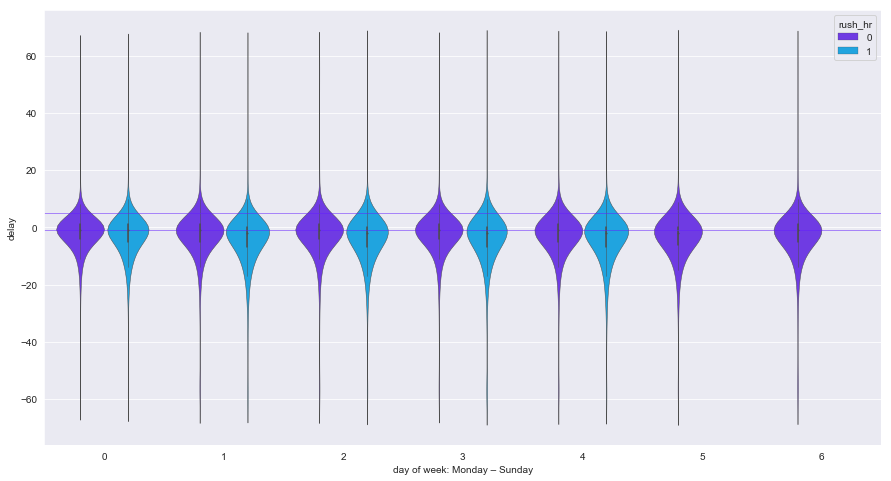

In [38]:
plt.figure(figsize=(15,8))
sns.violinplot(x='day_of_week', y='delay', hue='rush_hr', data=bus, linewidth=.5, bw=.5)
plt.xlabel('day of week: Monday – Sunday')
plt.axhline(y=5, linewidth=.5)
plt.axhline(y=-1, linewidth=.5)
plt.show()

#### Is it the weekend?
We'll create a binary variable show if it's the weekend. Looking at the associated graphs below, it seems as if the weekend schedule doens't really affect the busses all that much, unless the bus is an express bus. This is probably so large that we'll have to drop the express busses from the dataset. Many of these busses come from outside the city, so removing may help get rid of some outliers as well.

In [39]:
bus['weekend'] = np.where(bus.day_of_week>4,1,0)

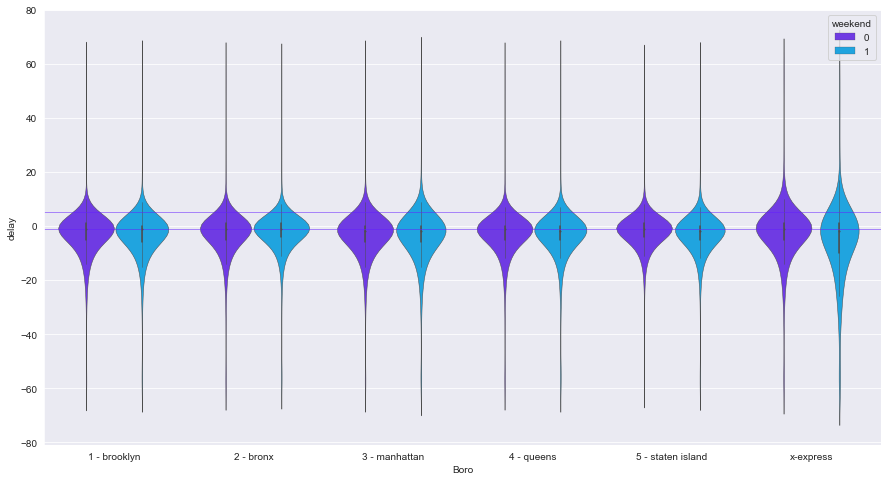

In [40]:
plt.figure(figsize=(15,8))
sns.violinplot(x='boro', y='delay', hue='weekend', data=bus, linewidth=.5, bw=.5)
plt.xlabel('Boro')
plt.axhline(y=5, linewidth=.5)
plt.axhline(y=-1, linewidth=.5)
plt.show()

In [41]:
bus[bus['boro']=='x-express'].describe()

RecordedAtTime  DirectionRef     OriginLat    OriginLong  \
count    39739.000000  39739.000000  39739.000000  39739.000000   
mean      1013.028511      0.458894     40.659410    -74.059090   
std        673.815641      0.498314      0.093898      0.106669   
min          0.000000      0.000000     40.506880    -74.232980   
25%        612.000000      0.000000     40.560760    -74.171091   
50%        848.000000      0.000000     40.640133    -74.012714   
75%       1712.000000      1.000000     40.760430    -73.977491   
max       2358.000000      1.000000     40.770035    -73.701868   

       DestinationLat  DestinationLong  VehicleLocation.Latitude  \
count    39739.000000     39739.000000              39739.000000   
mean        40.674531       -74.044785                 40.667986   
std          0.091320         0.104342                  0.073313   
min         40.508104       -74.230071                 40.502898   
25%         40.564227       -74.165755                 40.604303   
50%         40.716379       -73.991779                 40.685557   
75%         40.759917       -73.972702                 40.737544   
max         40.770593       -73.701382                 40.780723   

       VehicleLocation.Longitude  ExpectedArrivalTime  ScheduledArrivalTime  \
count               39739.000000         39739.000000          39739.000000   
mean                  -74.042515          1043.921135           1045.003171   
std                     0.083056           662.923558            662.690539   
min                   -74.252318             0.000000              0.000000   
25%                   -74.109239           632.000000            633.000000   
50%                   -74.013901           911.000000            911.000000   
75%                   -73.989329          1718.000000           1717.000000   
max                   -73.701491          2359.000000           2359.000000   

           ...              delay      on_time  boro_code  express      sbs  \
count      ...       39739.000000  39739.00000    39739.0  39739.0  39739.0   
mean       ...          -2.864013      0.48280        5.0      1.0      0.0   
std        ...           9.917932      0.49971        0.0      0.0      0.0   
min        ...         -60.000000      0.00000        5.0      1.0      0.0   
25%        ...          -5.000000      0.00000        5.0      1.0      0.0   
50%        ...          -1.000000      0.00000        5.0      1.0      0.0   
75%        ...           1.000000      1.00000        5.0      1.0      0.0   
max        ...          60.000000      1.00000        5.0      1.0      0.0   

           bus_code  line_avg_delay  line_delay_std       rush_hr  \
count  39739.000000    39739.000000    39739.000000  39739.000000   
mean     219.547321       -2.864013        9.785945      0.544503   
std        9.588855        1.092502        1.212972      0.498022   
min      208.000000       -4.519809        7.290646      0.000000   
25%      210.000000       -3.663664        8.916560      0.000000   
50%      217.000000       -2.773185        9.538174      1.000000   
75%      227.000000       -2.169598       11.170388      1.000000   
max      238.000000        0.243202       11.331348      1.000000   

            weekend  
count  39739.000000  
mean       0.082941  
std        0.275797  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 21 columns]

In [42]:
# drop the express busses from the data
bus = bus.drop(bus[bus['boro']=='x-express'].index)

bus.shape

(960261, 31)

#### Breakdown by date
All of the top 5 dates are weekdays. 2017-10-21 is the first weekend instance and it is 12th from the bottom.

In [43]:
bus['date'].value_counts()

2017-10-16    42022
2017-10-05    41855
2017-10-02    40669
2017-10-06    38989
2017-10-10    38865
2017-10-30    38805
2017-10-09    38489
2017-10-27    37604
2017-10-25    37271
2017-10-31    35518
2017-10-04    34840
2017-10-23    34786
2017-10-18    34663
2017-10-11    32715
2017-10-26    31996
2017-10-17    31641
2017-10-12    31102
2017-10-20    30324
2017-10-03    29266
2017-10-21    29034
2017-10-13    26749
2017-10-28    26648
2017-10-19    26105
2017-10-14    24464
2017-10-22    24142
2017-10-15    23951
2017-10-01    23247
2017-10-24    22938
2017-10-07    20015
2017-10-08    17654
2017-10-29    13894
Name: date, dtype: int64

#### How close to the stop?
Most busses are very close to or at their next stop.

In [44]:
bus.ArrivalProximityText.value_counts().head(10)

approaching       378831
< 1 stop away     322520
at stop           237592
0.6 miles away      5434
0.5 miles away      3788
0.7 miles away      3381
0.8 miles away      1606
1.0 miles away      1158
0.9 miles away      1148
1.1 miles away       496
Name: ArrivalProximityText, dtype: int64

In [45]:
bus.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'RecordedAtDateTime', 'day_of_week', 'date',
       'delay', 'on_time', 'boro', 'boro_code', 'express', 'sbs', 'bus_code',
       'line_avg_delay', 'line_delay_std', 'rush_hr', 'weekend'],
      dtype='object')

In [46]:
bus['day_of_week']

bus.day_of_week.value_counts()

0    194771
1    158228
2    139489
4    133666
3    131058
6    102888
5    100161
Name: day_of_week, dtype: int64

#### Distance Graph
This graph confirms what we saw above with the table, that most busses are at or near the next stop. What is interesting is the gulf between the busses that are over 6000 away and the rest of the data. We wil drop those and see where it leaves or data.

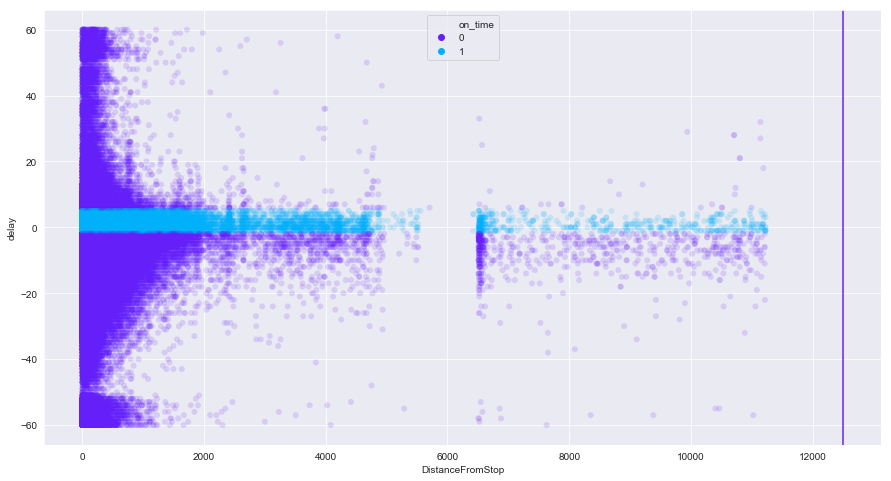

In [47]:
bus["DistanceFromStop"] = pd.to_numeric(bus["DistanceFromStop"])
plt.figure(figsize=(15,8))
sns.scatterplot(x="DistanceFromStop", y="delay", hue='on_time',
                linewidth=0, data=bus, alpha=.15)
plt.axvline(x=12500)
plt.show()

#### Distance Graph
Dropping these gives us a lot closer of a look at the data. The distribution of these is nice and it does seem that the farther away from the stop, the closer the bus gets to being on-time. Also are far less datapoints that are farther away from the stop than near it.

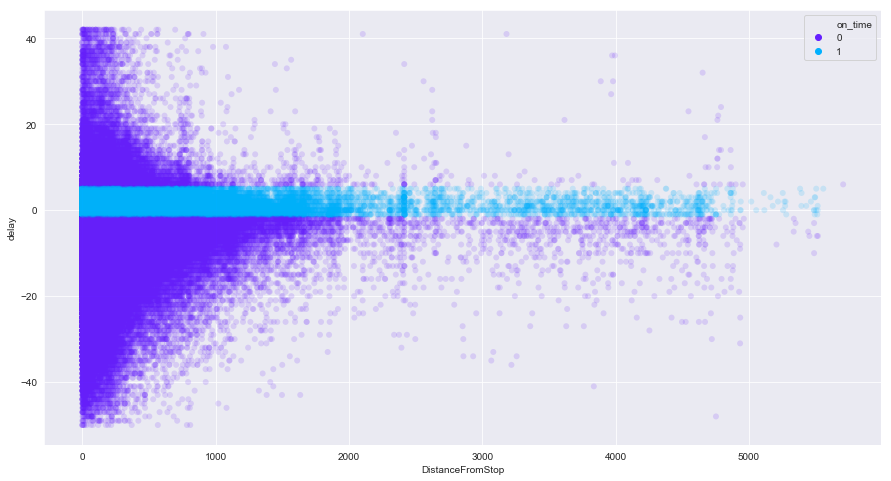

In [48]:
bus = bus.drop(bus[bus['DistanceFromStop']>6000].index)
bus = bus.drop(bus[bus['delay']>42].index)
bus = bus.drop(bus[bus['delay']<-50].index)

bus["DistanceFromStop"] = pd.to_numeric(bus["DistanceFromStop"])
plt.figure(figsize=(15,8))
sns.scatterplot(x="DistanceFromStop", y="delay", hue='on_time',
                linewidth=0, data=bus, alpha=.15)
#plt.axvline(x=12500)
plt.show()

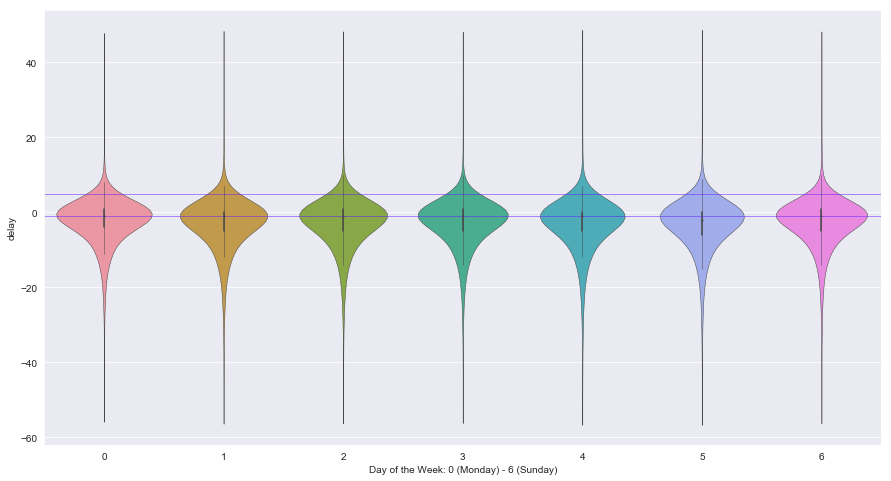

In [49]:
# Weekday doesn't seem to affect the bus all that much
plt.figure(figsize=(15,8))
sns.violinplot(x='day_of_week', y='delay', data=bus, linewidth=.5, bw=.5)
plt.xlabel(('Day of the Week: 0 (Monday) - 6 (Sunday)'))
plt.axhline(y=5, linewidth=.5)
plt.axhline(y=-1, linewidth=.5)
plt.show()

In [50]:
# Average delay for the published line
seller_plt = pd.DataFrame(bus[['PublishedLineName','delay', 'on_time']].groupby('PublishedLineName')['delay'].mean().sort_values(ascending=False))
seller_plt.reset_index(level=0, inplace=True)
seller_plt.sort_values(by='delay', ascending=True).head(10)

PublishedLineName     delay
207               S86 -7.906977
206               S84 -7.296703
205                M1 -5.911177
204               Q56 -5.649912
203               S81 -5.622449
202               B35 -5.528730
201                M5 -5.217507
200              Bx32 -4.975241
199                M2 -4.947130
198                M7 -4.877533

In [51]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949343 entries, 0 to 999999
Data columns (total 31 columns):
RecordedAtTime               949343 non-null float64
DirectionRef                 949343 non-null int64
PublishedLineName            949343 non-null category
OriginName                   949343 non-null object
OriginLat                    949343 non-null float64
OriginLong                   949343 non-null float64
DestinationName              949343 non-null object
DestinationLat               949343 non-null float64
DestinationLong              949343 non-null float64
VehicleRef                   949343 non-null object
VehicleLocation.Latitude     949343 non-null float64
VehicleLocation.Longitude    949343 non-null float64
NextStopPointName            949343 non-null object
ArrivalProximityText         949343 non-null object
DistanceFromStop             949343 non-null int64
ExpectedArrivalTime          949343 non-null float64
ScheduledArrivalTime         949343 non-null floa

In [52]:
bus['OriginName'].value_counts().head()

MERRICK BL/ARCHER AV    13645
E 126 ST/2 AV           13284
W 179 ST/BROADWAY       12840
TEARDROP/LAYOVER        10104
KINGS PLAZA              9878
Name: OriginName, dtype: int64

In [53]:
bus.loc[bus['on_time']==0].VehicleRef.value_counts()

NYCT_5816    256
NYCT_5845    247
NYCT_5906    246
NYCT_5912    245
NYCT_6023    243
NYCT_5310    242
NYCT_6051    241
NYCT_6037    239
NYCT_6039    239
NYCT_5902    235
NYCT_5820    234
NYCT_5261    233
NYCT_5321    233
NYCT_5858    232
NYCT_6116    231
NYCT_6043    229
NYCT_4582    229
NYCT_6003    228
NYCT_6063    227
NYCT_5798    226
NYCT_7364    225
NYCT_5253    224
NYCT_5853    223
NYCT_5309    223
NYCT_6020    223
NYCT_6065    222
NYCT_4118    222
NYCT_6118    222
NYCT_6047    222
NYCT_5947    221
            ... 
NYCT_8473      4
NYCT_4868      4
NYCT_4473      4
NYCT_2544      3
NYCT_7349      3
NYCT_2514      3
NYCT_2693      3
NYCT_2549      3
NYCT_4469      2
NYCT_1271      2
NYCT_7390      2
NYCT_7338      2
NYCT_2562      2
NYCT_2683      2
NYCT_7794      2
NYCT_5935      2
NYCT_2684      1
NYCT_2569      1
NYCT_5565      1
NYCT_2774      1
NYCT_2540      1
NYCT_4329      1
NYCT_2546      1
NYCT_2710      1
NYCT_2597      1
NYCT_2543      1
NYCT_2691      1
NYCT_5884     

In [54]:
# Strip the NYCT at the beginning of each of the reference numbers
bus.VehicleRef = bus.VehicleRef.map(lambda x: x.lstrip('NYCT_'))
bus.VehicleRef = pd.to_numeric(bus.VehicleRef)
bus.VehicleRef.describe()

count    949343.000000
mean       5296.665468
std        2290.579795
min         230.000000
25%        4347.000000
50%        5677.000000
75%        7063.000000
max        9674.000000
Name: VehicleRef, dtype: float64

In [55]:
# Add the average delay for each of the actual vehicles as well

vehavgdelays = pd.DataFrame(bus.groupby('VehicleRef')['delay'].mean().sort_values(ascending=False))
vehavgdelays.columns = ['veh_avg_delay']

bus = bus.merge(vehavgdelays, on='VehicleRef', how='inner')
bus.head()

RecordedAtTime  DirectionRef PublishedLineName             OriginName  \
0          1351.0             0               Bx9  E TREMONT AV/E 177 ST   
1          1721.0             1               Bx9      BROADWAY/W 262 ST   
2          1842.0             0               Bx9  E TREMONT AV/E 177 ST   
3          1652.0             0               Bx9  E TREMONT AV/E 177 ST   
4           519.0             1               Bx9      W 225 ST/BROADWAY   

   OriginLat  OriginLong   DestinationName  DestinationLat  DestinationLong  \
0  40.839994  -73.879938  RIVERDALE 262 ST       40.910081       -73.896495   
1  40.910104  -73.896730        WEST FARMS       40.840642       -73.879807   
2  40.839994  -73.879938  RIVERDALE 262 ST       40.910081       -73.896495   
3  40.839994  -73.879938  RIVERDALE 262 ST       40.910081       -73.896495   
4  40.874274  -73.909375        WEST FARMS       40.840642       -73.879807   

   VehicleRef      ...            boro  boro_code express sbs  bus_code  \
0        5696      ...       2 - bronx          1       0   0        96   
1        5696      ...       2 - bronx          1       0   0        96   
2        5696      ...       2 - bronx          1       0   0        96   
3        5696      ...       2 - bronx          1       0   0        96   
4        5696      ...       2 - bronx          1       0   0        96   

   line_avg_delay  line_delay_std rush_hr  weekend veh_avg_delay  
0       -2.321765        7.891034       0        1     -3.155844  
1       -2.321765        7.891034       0        1     -3.155844  
2       -2.321765        7.891034       1        0     -3.155844  
3       -2.321765        7.891034       1        0     -3.155844  
4       -2.321765        7.891034       0        0     -3.155844  

[5 rows x 32 columns]

#### Create a single location variable
Location calculated from Tom's comment here: https://stackoverflow.com/questions/4637031/geospatial-indexing-with-redis-sinatra-for-a-facebook-app. In the graph, the farther away a bus gets away from the center it seems like there are less delays. Again reinforces that most busses are early vs late.

In [56]:
bus['vehical_location'] = (bus['VehicleLocation.Latitude']+90)*180+bus['VehicleLocation.Longitude'] 
bus['destination_location'] = (bus['DestinationLat']+90)*180+bus['DestinationLong']
bus['origin_location'] = (bus['OriginLat']+90)*180+bus['OriginLong']

In [57]:
cent_park = int(round((40.7829+90)*180+(-73.9654)))
prosp_park = int(round((40.6602+90)*180+(-73.9690)))
flushing_mead = int(round((40.7397+90)*180+(-73.8408)))
fordham = int(round((40.8620+90)*180+(-73.8857)))
wagner = int(round((40.6150+90)*180+(-74.0944)))
print(cent_park, prosp_park, flushing_mead, fordham, wagner)

23467 23445 23459 23481 23437


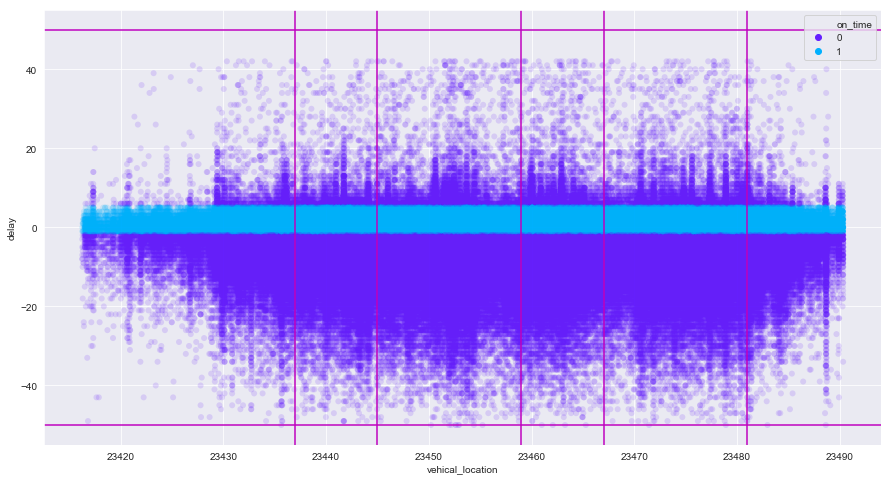

In [58]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='vehical_location', y='delay', hue='on_time',
                linewidth=0, data=bus, alpha=.15)
plt.axvline(x=cent_park, color='m', label='central park')
plt.axvline(x=prosp_park, color='m', label='prospect park')
plt.axvline(x=flushing_mead, color='m', label='flushing meadows')
plt.axvline(x=fordham, color='m', label='fordham')
plt.axvline(x=wagner, color='m', label='wagner college')
plt.axhline(y=-50, color='m')
plt.axhline(y=50, color='m')
plt.show()

In [59]:
bus.shape

(949343, 35)

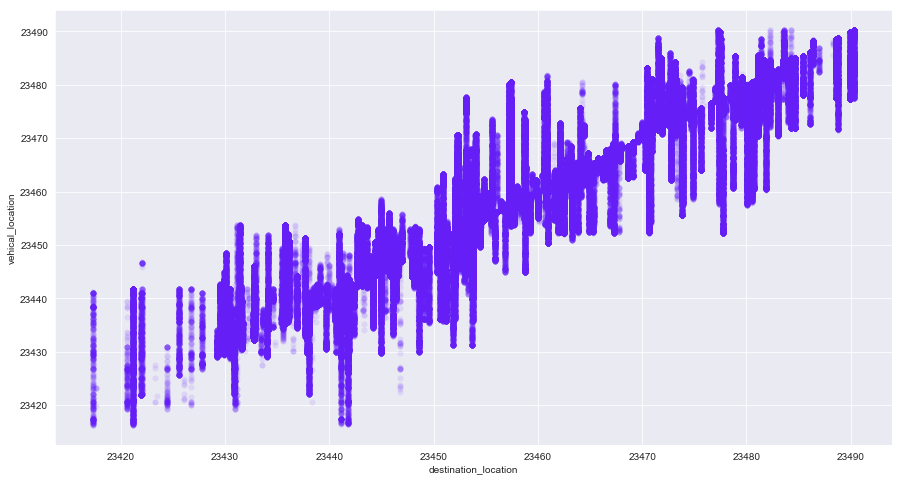

In [60]:
# This graph is pretty useless. A little too much overlapping.
plt.figure(figsize=(15,8))
sns.scatterplot(x='destination_location', y='vehical_location',
                linewidth=0, data=bus.loc[bus.on_time==0], alpha=.1)
plt.show()

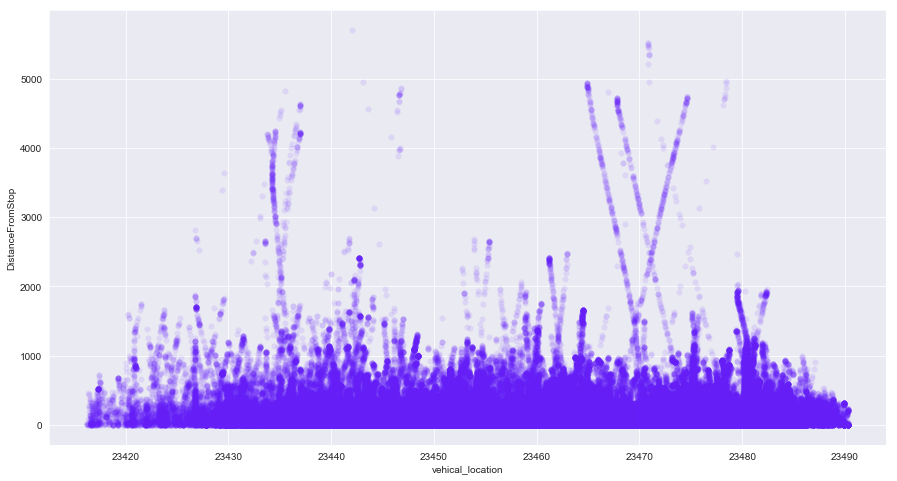

In [61]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='vehical_location', y='DistanceFromStop',
                linewidth=0, data=bus.loc[bus.on_time==0], alpha=.1)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
sns.jointplot(kind='hex',x='vehical_location', y='delay', data=bus)
plt.show()

#### Plotting Every Bus
Unfornately the graphs don't tell us too much below other than that Staten Island seems to have more on-time busses and that northern Queens is extremely underserved with bus service.

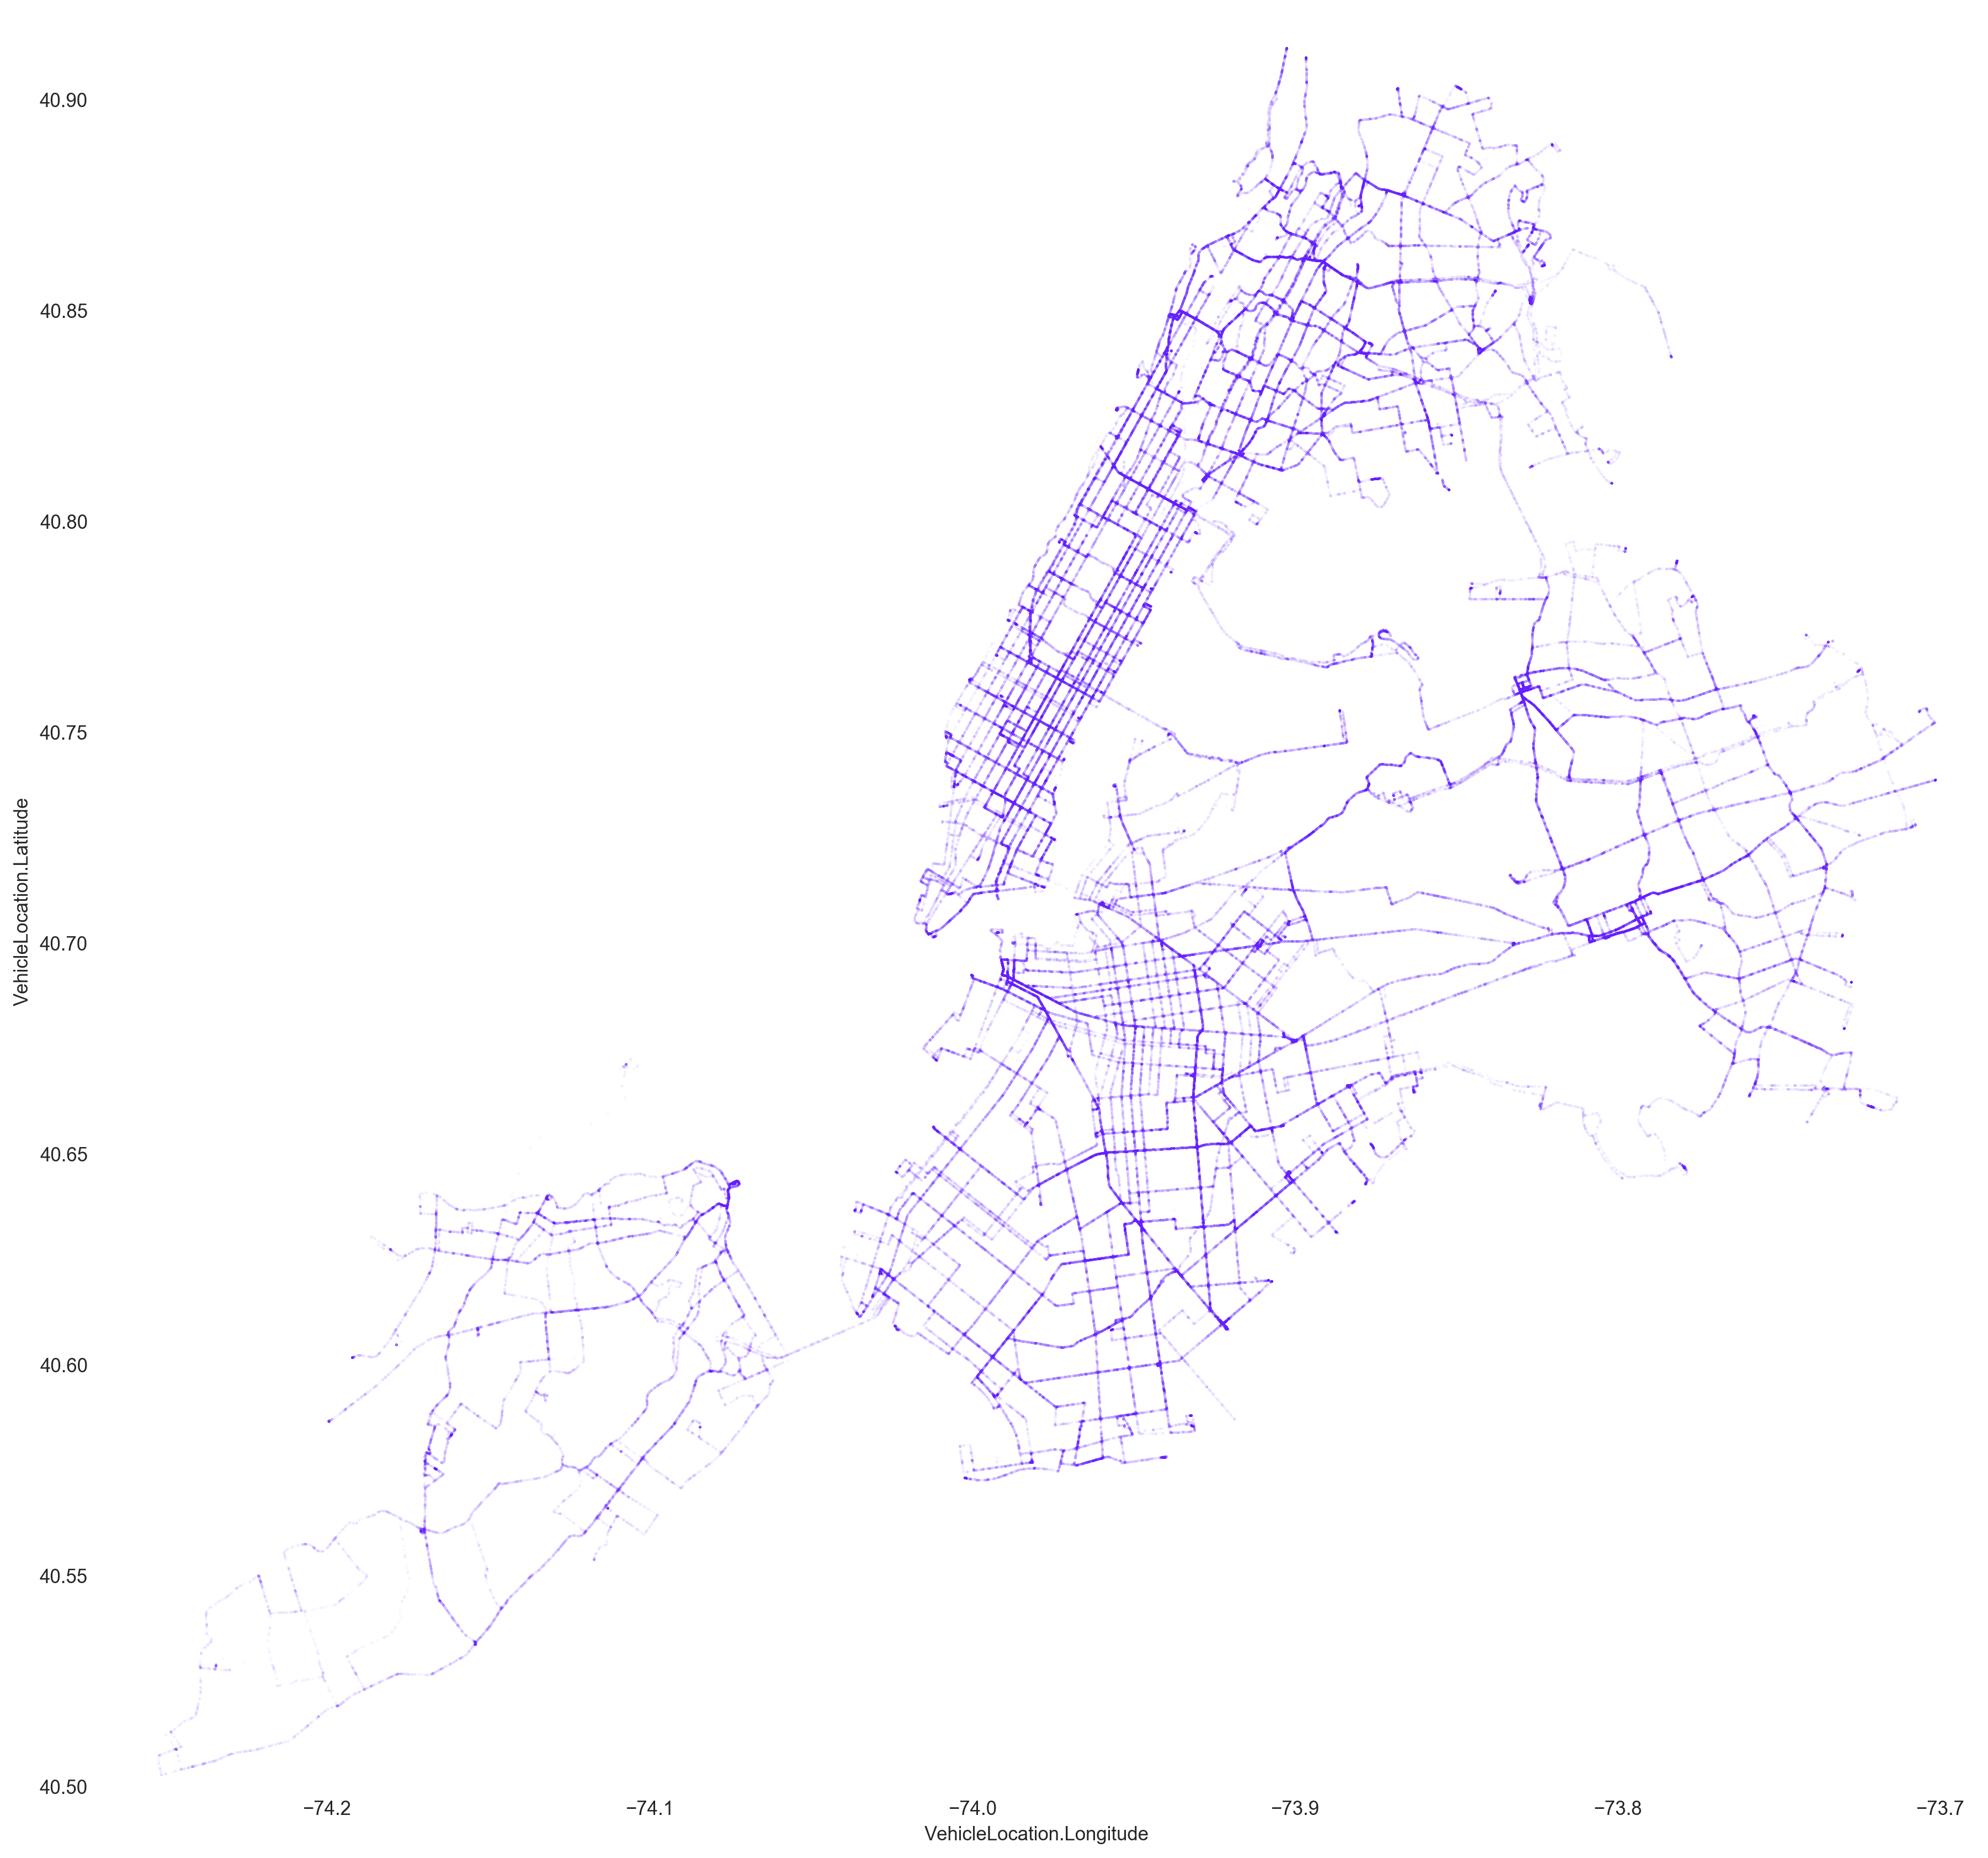

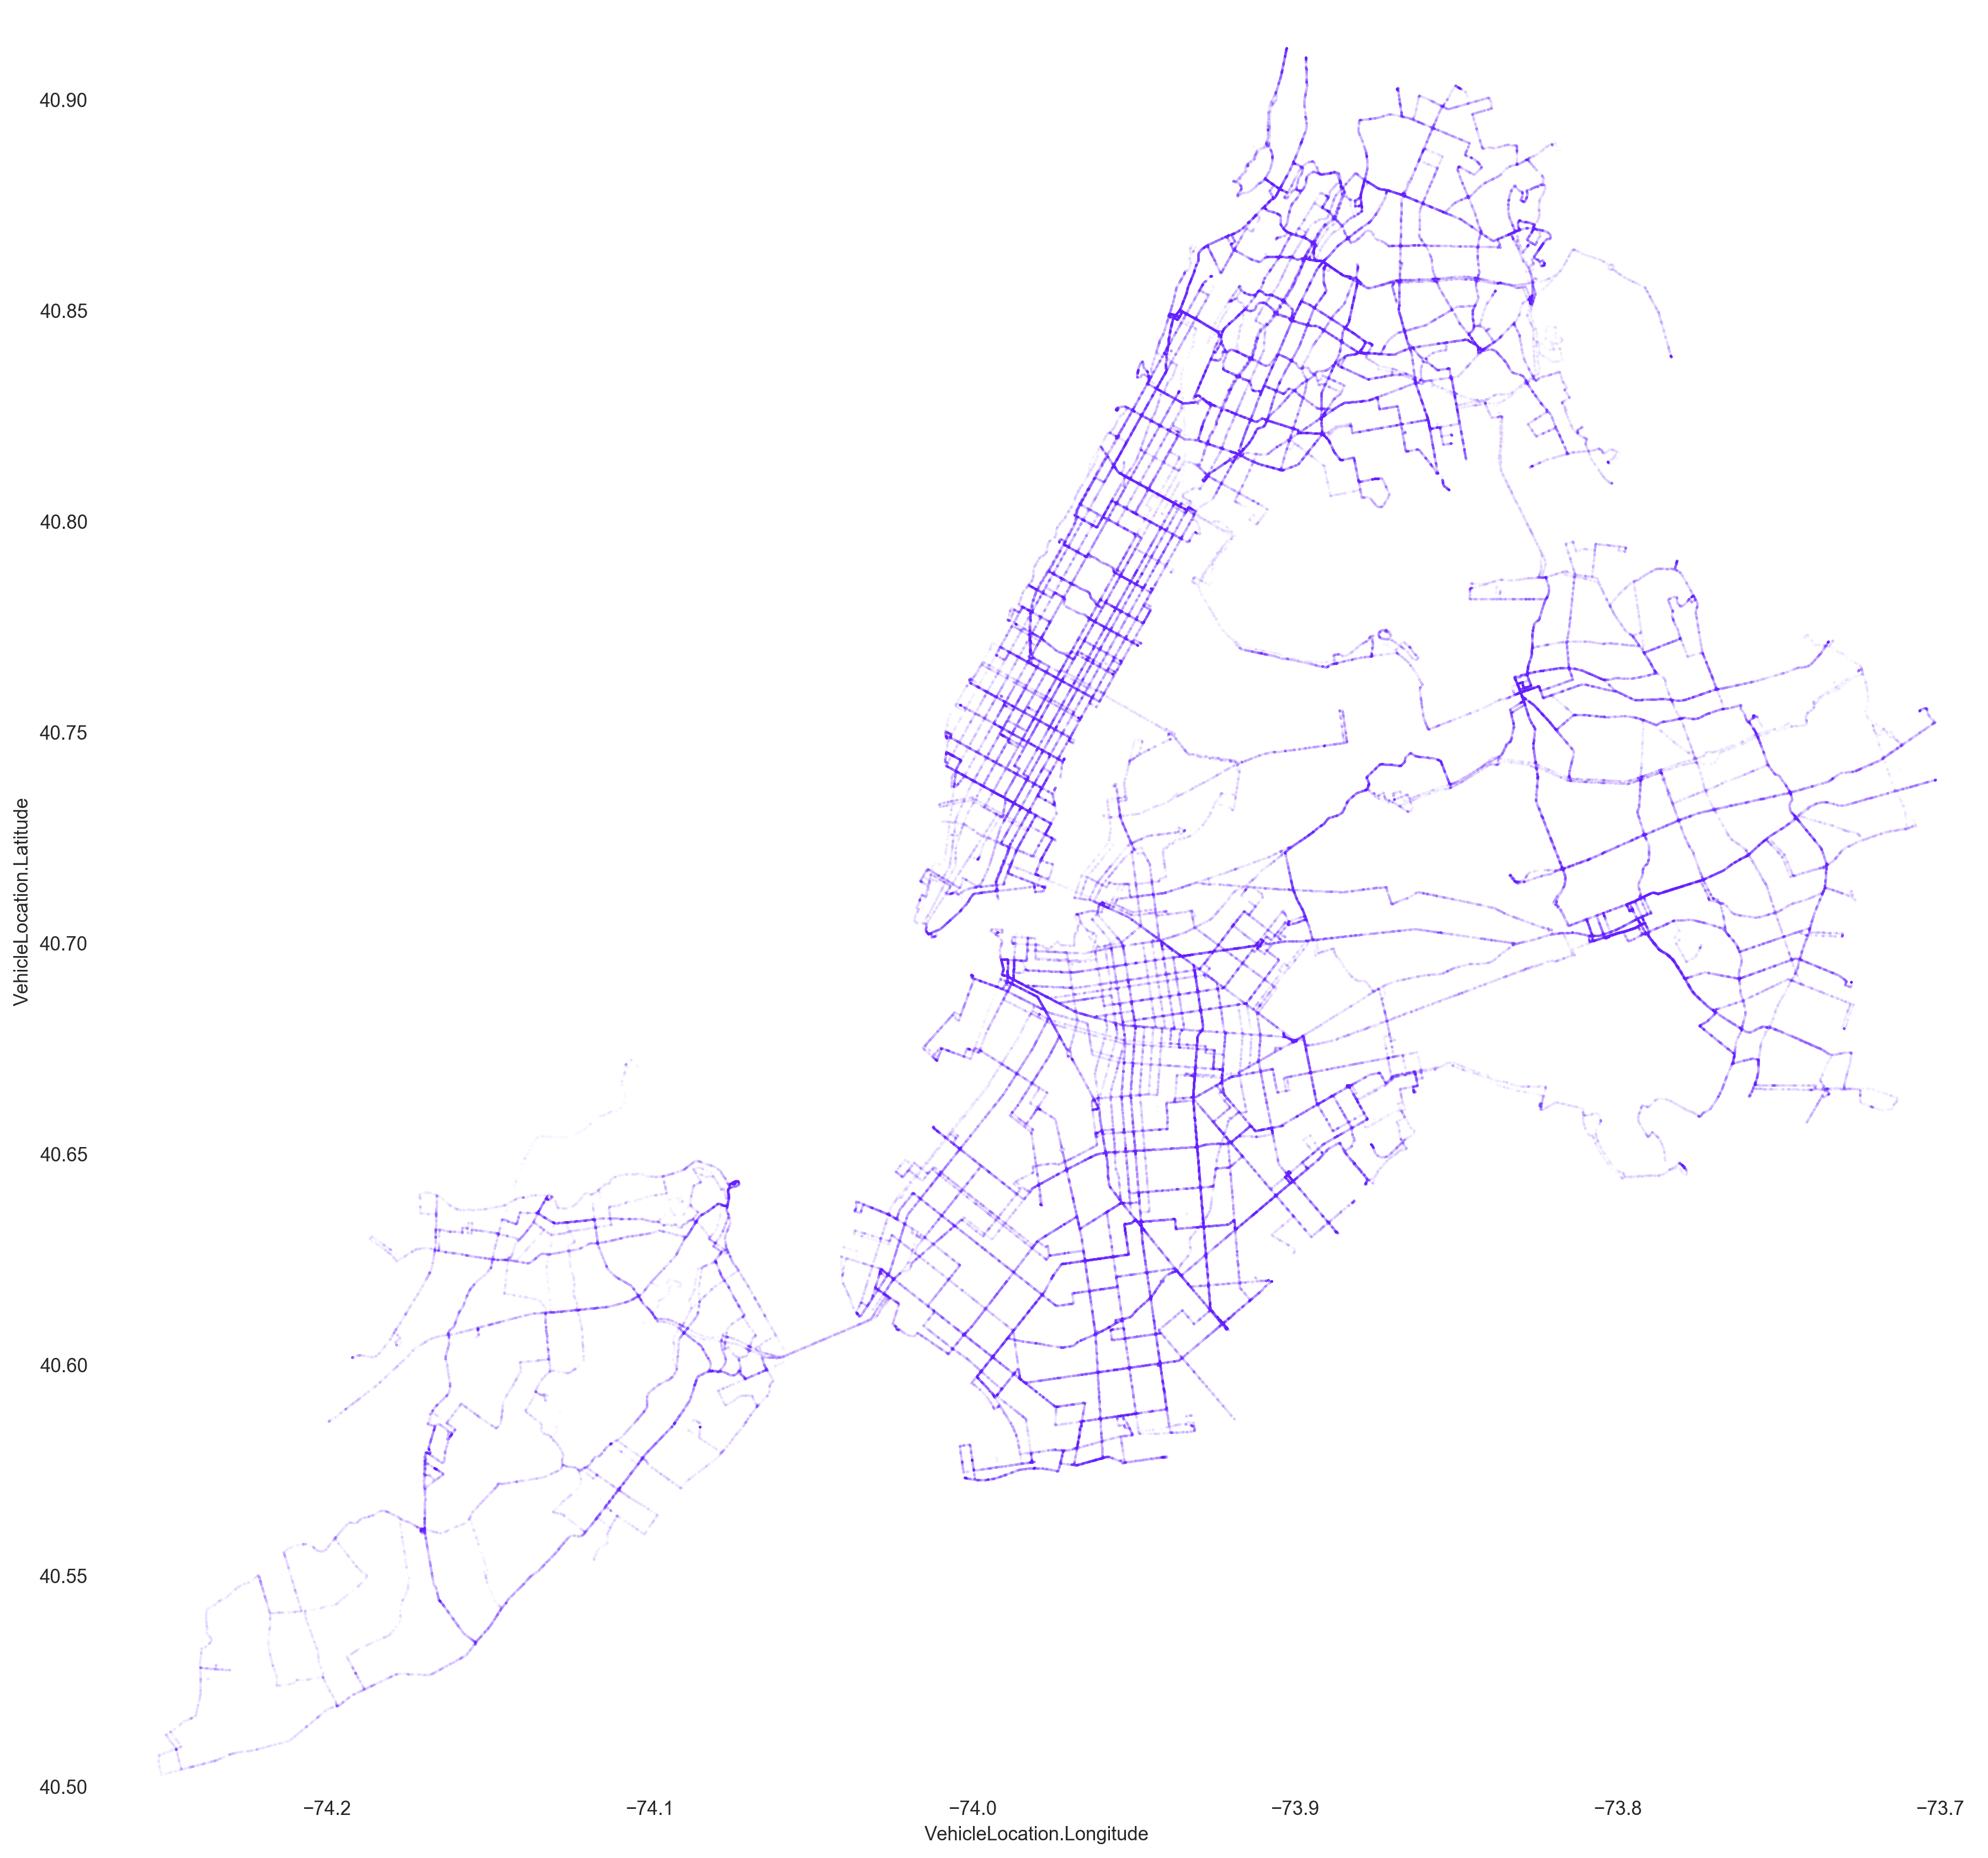

In [63]:
import matplotlib   
#Inline Plotting for Ipython Notebook 
%matplotlib inline 

#pd.options.display.mpl_style = 'default' #Better Styling  
new_style = {'grid': False} #Remove grid  
matplotlib.rc('axes', **new_style)  
from matplotlib import rcParams  
rcParams['figure.figsize'] = (17.5, 17) #Size of figure  
rcParams['figure.dpi'] = 250

P1=bus.loc[bus['on_time']==0].plot(kind='scatter', x='VehicleLocation.Longitude', y='VehicleLocation.Latitude',
           color='#651FFF',xlim=(-74.27,-73.69),ylim=(40.5, 40.92),s=.03,alpha=.1) #,s=.03,alpha=.1
P1.set_facecolor('#ffffff') #Background Color
P2=bus.loc[bus['on_time']==1].plot(kind='scatter', x='VehicleLocation.Longitude', y='VehicleLocation.Latitude',
           color='#651FFF',xlim=(-74.27,-73.69),ylim=(40.5, 40.92),s=.03,alpha=.1)
P2.set_facecolor('#ffffff') #Background Color

In [64]:
bus.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'RecordedAtDateTime', 'day_of_week', 'date',
       'delay', 'on_time', 'boro', 'boro_code', 'express', 'sbs', 'bus_code',
       'line_avg_delay', 'line_delay_std', 'rush_hr', 'weekend',
       'veh_avg_delay', 'vehical_location', 'destination_location',
       'origin_location'],
      dtype='object')

In [65]:
bus.DestinationName.value_counts().head()

WASHINGTON HTS GW BRIDGE    14112
ST GEORGE FERRY              9122
FLUSHING  MAIN ST STA        8258
W FARMS RD SOUTHERN BL       7984
FLUSHING MAIN ST STA         6137
Name: DestinationName, dtype: int64

#### Calculate Distance
Using Geopy, we'll calculate the distance a bus is into it's route then also the total route length.

In [66]:
# calculate the route distance basec upon destination & origin 
import math
import geopy.distance
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

destination = (bus.DestinationLat, bus.DestinationLong)
origin = (bus.OriginLat, bus.OriginLong)
location = (bus['VehicleLocation.Latitude'], bus['VehicleLocation.Longitude'])
bus['route_length'] = bus.progress_apply(lambda x: geopy.distance.geodesic((x['DestinationLat'], x['DestinationLong']), (x['OriginLat'], x['OriginLong'])).miles, axis = 1)
bus['distance_into_route'] = bus.progress_apply(lambda x: geopy.distance.geodesic((x['VehicleLocation.Latitude'], x['VehicleLocation.Longitude']), (x['OriginLat'], x['OriginLong'])).miles, axis = 1)

bus['percent_into_route'] = bus['distance_into_route'] / bus['route_length']

bus[['PublishedLineName','OriginName','NextStopPointName','route_length','distance_into_route','percent_into_route']].tail(120)

100%|██████████| 949343/949343 [05:45<00:00, 2747.31it/s]


PublishedLineName                            OriginName  \
949223           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949224           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949225           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949226           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949227           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949228           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949229           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949230           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949231           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949232           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949233           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949234           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949235           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949236           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949237           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949238           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949239           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949240           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949241           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949242           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949243           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949244           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949245           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949246           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949247           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949248           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949249           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949250           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
949251           Bx6-SBS              FOOD CENTER DR/MARKET ST   
949252           Bx6-SBS  RIVERSIDE DR W/157-10 RIVERSIDE DR W   
...                  ...                                   ...   
949313               S89                  RICHMOND AV/HYLAN BL   
949314               S89            RT 440/34 ST HBLR STA LOOP   
949315               S89                  RICHMOND AV/HYLAN BL   
949316               S89                  RICHMOND AV/HYLAN BL   
949317               S89            RT 440/34 ST HBLR STA LOOP   
949318               S89            RT 440/34 ST HBLR STA LOOP   
949319               S89                  RICHMOND AV/HYLAN BL   
949320               S89                  RICHMOND AV/HYLAN BL   
949321               S89                  RICHMOND AV/HYLAN BL   
949322               S89                  RICHMOND AV/HYLAN BL   
949323               S89                  RICHMOND AV/HYLAN BL   
949324               S89            RT 440/34 ST HBLR STA LOOP   
949325               S89            RT 440/34 ST HBLR STA LOOP   
949326               S89                  RICHMOND AV/HYLAN BL   
949327               S89            RT 440/34 ST HBLR STA LOOP   
949328               S89            RT 440/34 ST HBLR STA LOOP   
949329               S89                  RICHMOND AV/HYLAN BL   
949330               S89                  RICHMOND AV/HYLAN BL   
949331               S89            RT 440/34 ST HBLR STA LOOP   
949332               S89            RT 440/34 ST HBLR STA LOOP   
949333               S89                  RICHMOND AV/HYLAN BL   
949334               S89                  RICHMOND AV/HYLAN BL   
949335               S89            RT 440/34 ST HBLR STA LOOP   
949336               S89                  RICHMOND AV/HYLAN BL   
949337           M34-SBS              FERRY TERMINAL/FDR DRIVE   
949338           M34-SBS                         W 34 ST/12 AV   
949339           M34-SBS              FERRY TERMINAL/FDR DRIVE   
949340           M34-SBS                         W 34 ST/12 AV   
949341           M34-SBS                       

In [67]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949343 entries, 0 to 949342
Data columns (total 38 columns):
RecordedAtTime               949343 non-null float64
DirectionRef                 949343 non-null int64
PublishedLineName            949343 non-null category
OriginName                   949343 non-null object
OriginLat                    949343 non-null float64
OriginLong                   949343 non-null float64
DestinationName              949343 non-null object
DestinationLat               949343 non-null float64
DestinationLong              949343 non-null float64
VehicleRef                   949343 non-null int64
VehicleLocation.Latitude     949343 non-null float64
VehicleLocation.Longitude    949343 non-null float64
NextStopPointName            949343 non-null object
ArrivalProximityText         949343 non-null object
DistanceFromStop             949343 non-null int64
ExpectedArrivalTime          949343 non-null float64
ScheduledArrivalTime         949343 non-null float

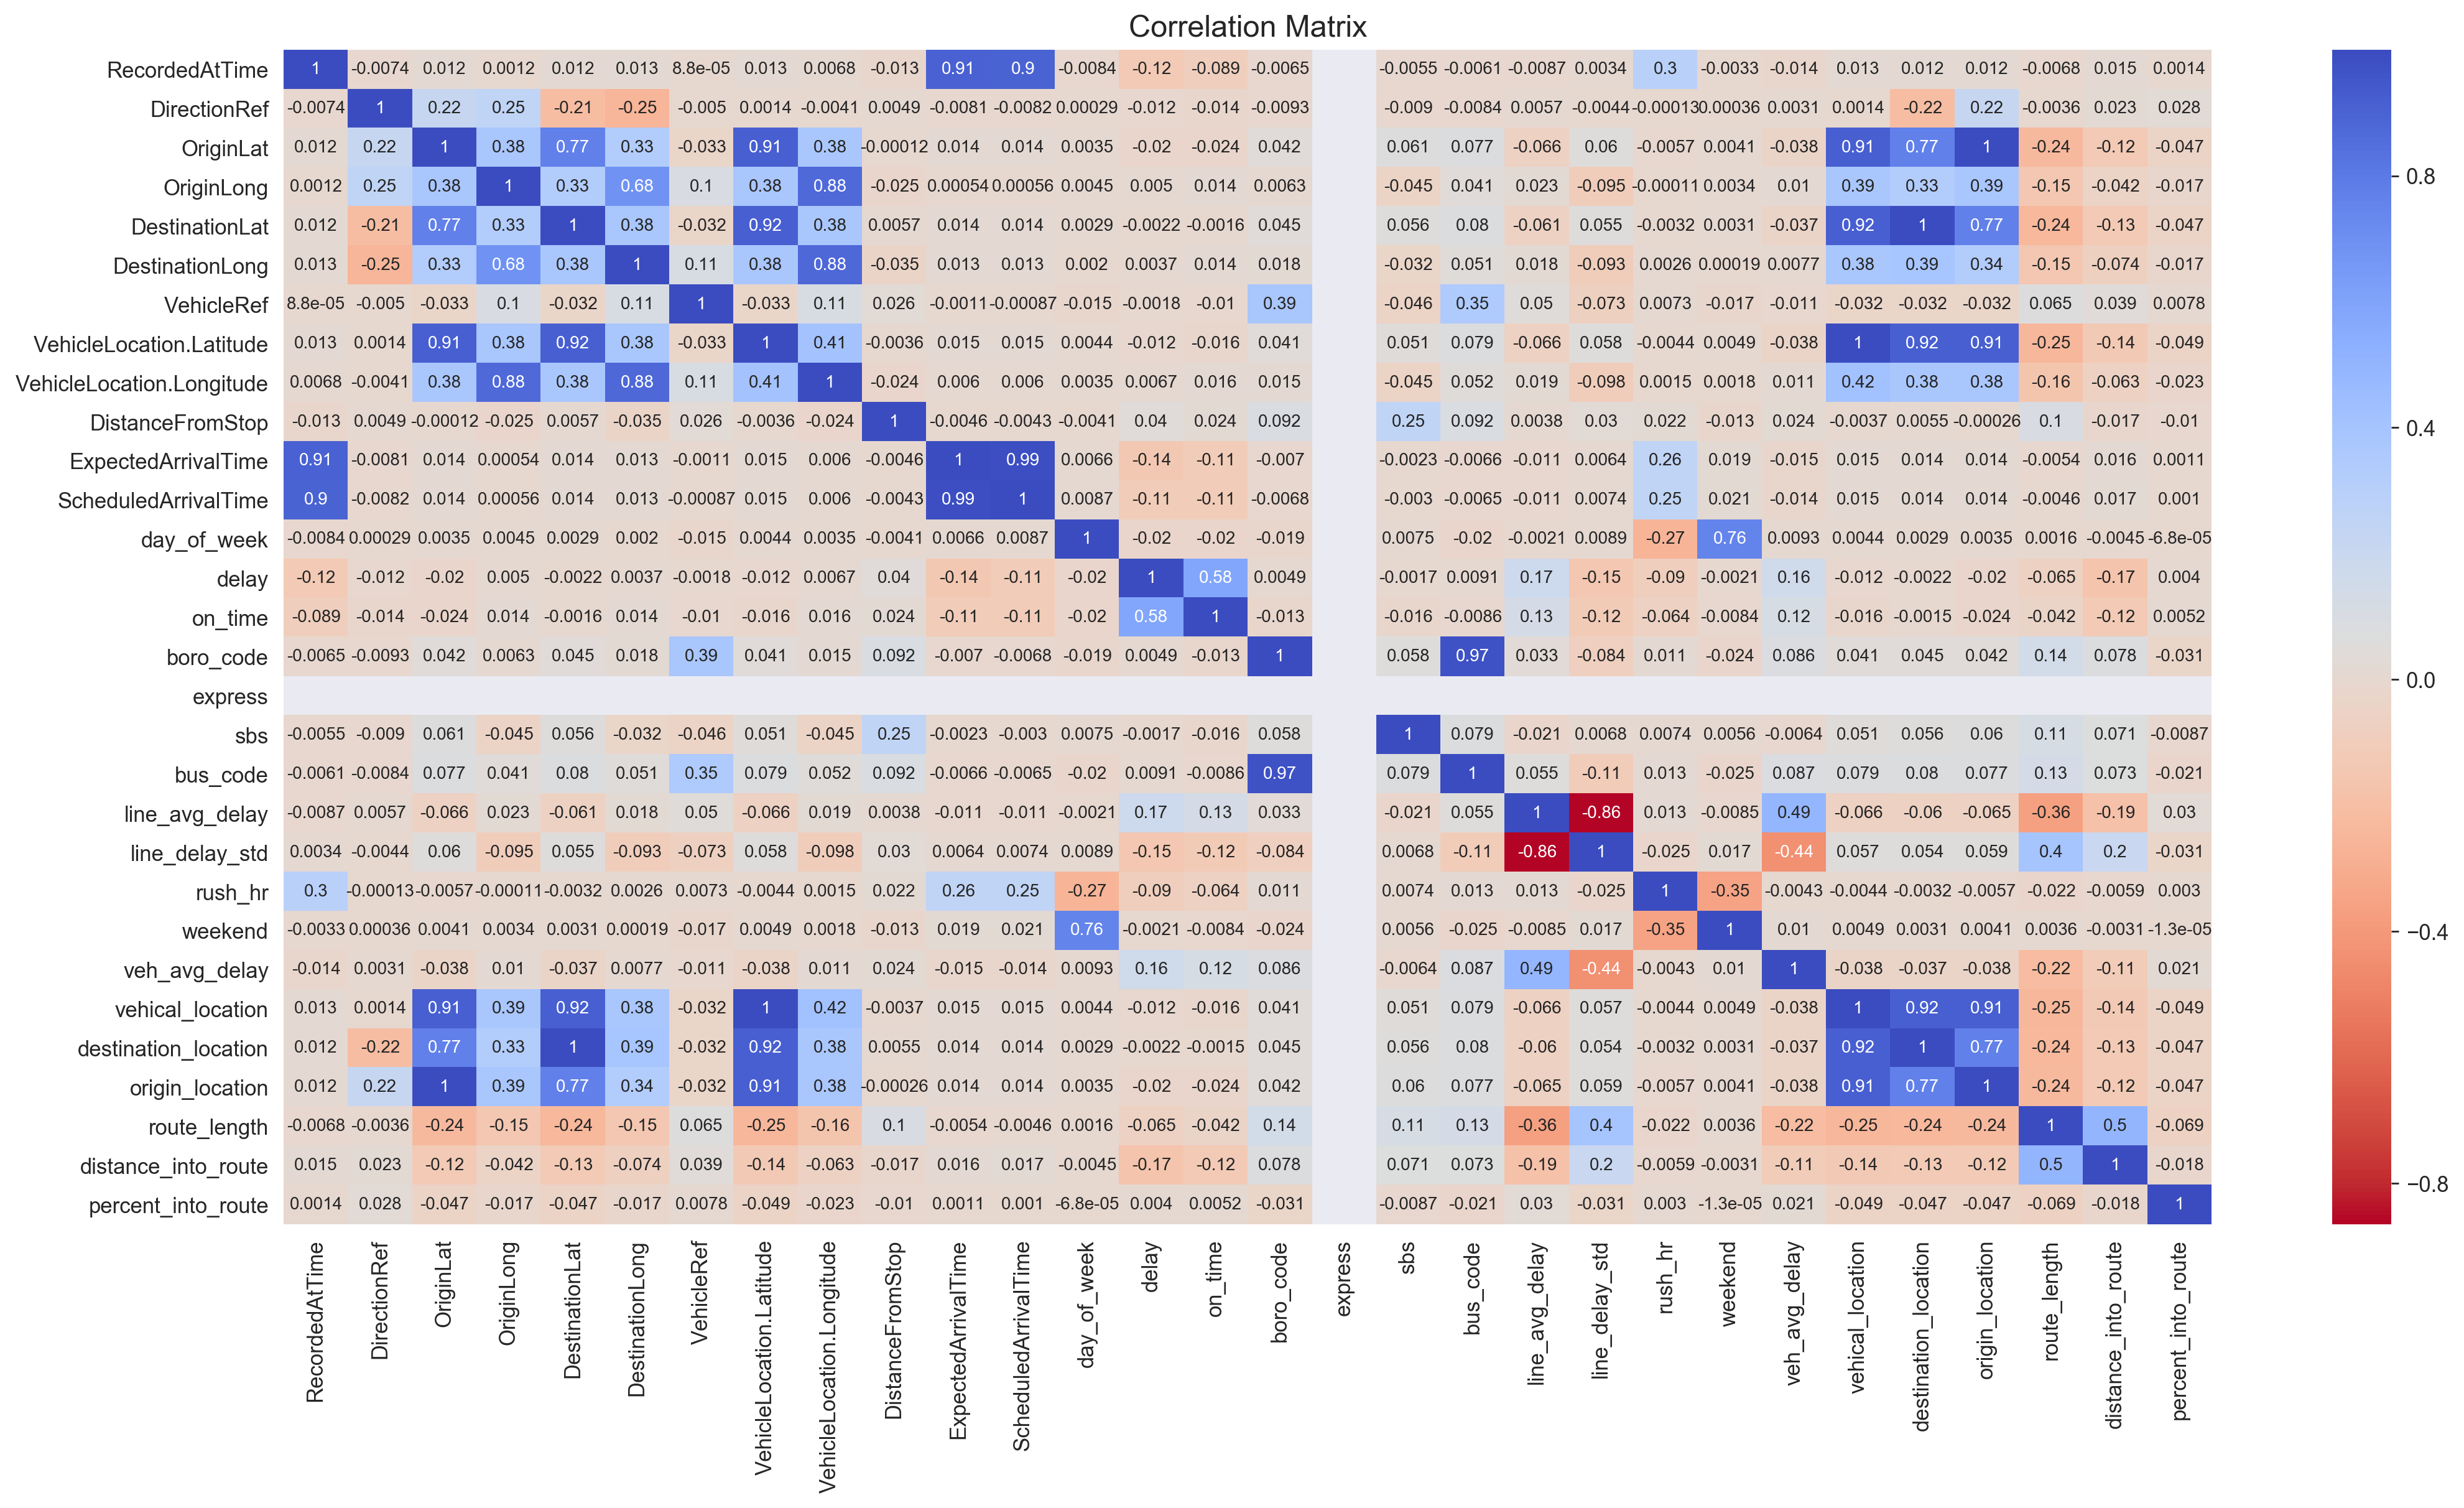

In [68]:
plt.figure(figsize=(20,10))
sample_corr = bus.corr()
sns.heatmap(sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8})
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [69]:
# add AUC to the models

In [70]:
bus.dtypes

RecordedAtTime                      float64
DirectionRef                          int64
PublishedLineName                  category
OriginName                           object
OriginLat                           float64
OriginLong                          float64
DestinationName                      object
DestinationLat                      float64
DestinationLong                     float64
VehicleRef                            int64
VehicleLocation.Latitude            float64
VehicleLocation.Longitude           float64
NextStopPointName                    object
ArrivalProximityText                 object
DistanceFromStop                      int64
ExpectedArrivalTime                 float64
ScheduledArrivalTime                float64
RecordedAtDateTime           datetime64[ns]
day_of_week                           int64
date                                 object
delay                               float64
on_time                               int64
boro                            

In [71]:
bus.shape

(949343, 38)

## Modeling
We'll use Select K Best to extract the best features from data, then we will fit to Logistic Regression, Naive Bayes, Decision Tree, Random Forest, and Gradient Boosted Decision Tree.

In [72]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X = bus.drop(['PublishedLineName', 'OriginName','DestinationName', 'NextStopPointName',
              'ArrivalProximityText','boro','date','ExpectedArrivalTime', 'delay','on_time','RecordedAtDateTime'], 1)
y = bus['on_time']

selector=SelectKBest(score_func=f_classif, k=26)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05].reset_index()

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [13] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


index                  Attribute       F Score        P Value  Support
0      16             line_avg_delay  16948.231462   0.000000e+00     True
1      25        distance_into_route  14627.996248   0.000000e+00     True
2      17             line_delay_std  13329.779371   0.000000e+00     True
3      20              veh_avg_delay  12857.922009   0.000000e+00     True
4      10       ScheduledArrivalTime  11648.756011   0.000000e+00     True
5       0             RecordedAtTime   7599.470048   0.000000e+00     True
6      18                    rush_hr   3911.988626   0.000000e+00     True
7      24               route_length   1640.624392   0.000000e+00     True
8       2                  OriginLat    567.421540  2.224031e-125     True
9      23            origin_location    561.402999  4.524595e-124     True
10      9           DistanceFromStop    535.402068  2.035189e-118     True
11     11                day_of_week    373.194212   3.915008e-83     True
12      8  VehicleLocation.Longitude    243.223436   7.919390e-55     True
13      7   VehicleLocation.Latitude    242.592945   1.086738e-54     True
14     21           vehical_location    238.842188   7.140691e-54     True
15     14                        sbs    233.487058   1.049989e-52     True
16      5            DestinationLong    192.063365   1.138197e-43     True
17      3                 OriginLong    184.311943   5.596737e-42     True
18      1               DirectionRef    178.119876   1.257790e-40     True
19     12                  boro_code    156.823587   5.630497e-36     True
20      6                 VehicleRef    101.595794   6.827868e-24     True
21     15                   bus_code     70.924194   3.717235e-17     True
22     19                    weekend     67.304738   2.329075e-16     True
23     26         percent_into_route     25.748085   3.890859e-07     True

In [73]:
X = bus[key_vals]
y = bus['on_time']

from sklearn import preprocessing

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X,y)

X = preprocessing.scale(X)
#y = StandardScaler().fit_transform(y)

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.


### Logistic Regression
Logistic Regression only achieving a 59% accuracy is somewhat disappointing and you would hope that it would be able to do better but the lack of really any type of linearity in the data may mean that this data isn't all that well suited for a logistic regression method. The data doesn't seem to overfit and the precision and recall scores are in line with the general accuracy score and both of them are performing at similar levels for both on-time and not on-time busses. That may be a good sign for future models, even if logistic regression won't be what works for us.

In [76]:
# How long will it take
from datetime import datetime
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Train Percentage accuracy:
0.5962034081125607

Test Percentage accuracy:
0.5959989213604342

Cross Validation:
[0.59563068 0.59706324 0.5965548  0.59531183 0.59638626]

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.56      0.58    117483
           1       0.59      0.63      0.61    119853

   micro avg       0.60      0.60      0.60    237336
   macro avg       0.60      0.60      0.60    237336
weighted avg       0.60      0.60      0.60    237336


Duration: 0:00:27.632180


In [89]:
start_time = datetime.now()
# get rid of the warnings
import warnings
warnings.filterwarnings("ignore")

# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'C':[1e9,.5,1,3,5,10], 'max_iter':[50,100,150,300,500], 'penalty':['l1','l2']}

# Start the grid search again
grid_DT = GridSearchCV(lr, param_grid, cv=2, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:')
print(grid_DT.best_params_)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 3))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.1min finished


Best score for data:
{'C': 0.5, 'max_iter': 100, 'penalty': 'l1'}
Train Percentage accuracy:
0.5962034081125607

Test Percentage accuracy:
0.5959989213604342

Cross Validation:
[0.59619023 0.59581604 0.59637643]

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.56      0.58    117483
           1       0.59      0.63      0.61    119853

   micro avg       0.60      0.60      0.60    237336
   macro avg       0.60      0.60      0.60    237336
weighted avg       0.60      0.60      0.60    237336


Duration: 0:03:21.655056


### Naive Bayes
Naive Bayes also doesn't seem to working all that well for us. Achieving a 57% accuracy is also disappointing but Naive Bayes is probably too simple of a model to be able to work all that well with this data. If we had more binary variables, maybe but not when dealing with the continuous variables we have.

In [131]:
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5761333807111447

Test Percentage accuracy:
0.5764865001516837

Cross Validation:
[0.57459867 0.57669134 0.57616871 0.57681477 0.57630916]

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.54      0.56    117483
           1       0.58      0.61      0.59    119853

   micro avg       0.58      0.58      0.58    237336
   macro avg       0.58      0.58      0.58    237336
weighted avg       0.58      0.58      0.58    237336


Duration: 0:00:03.674113


### K Nearest Neighbors
KNN shows some promise here, an improvement of accuracy over the other models we have run so far but still a 62% accuracy with a slight bit of overfitting is something we will want to improve on. There is promise here and the data using a lot of different continuous variable and lack of linear shape might be why we see a bit of an improvement here over the past models. Again, the precision and recall being very even over both outcomes is a good sign and shows our balancing the data helped us out.

In [ ]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[50,75,150,300,500,750]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [90]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6441931048430704

Test Percentage accuracy:
0.6208750463477939

Cross Validation:
[0.61680313 0.6177652  0.61778358 0.61635101 0.61684258]

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.62      0.62    117483
           1       0.62      0.63      0.62    119853

   micro avg       0.62      0.62      0.62    237336
   macro avg       0.62      0.62      0.62    237336
weighted avg       0.62      0.62      0.62    237336


Duration: 4:10:54.545705


### Decision Tree
Again, the improvement here is nice but not good enough. True to the decision tree's form, the model overfits quite  a bit but the nearly 70% accuracy on the train set shows that we might have a bit more luck with the different variations of the decision tree. In my different tests, the more you raised the max depth on the decision tree, the higher the train accuracy went up. This didn't effect the test accuracy or the cross validation at all but again shows that if we can fix the overfitting problem, the decision tree based approach may be our best bet.

In [91]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6981686977796566

Test Percentage accuracy:
0.6059721239087201

Cross Validation:
[0.60185952 0.5975829  0.60184268 0.60354913 0.60443396]

Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.58      0.59    117483
           1       0.61      0.63      0.62    119853

   micro avg       0.61      0.61      0.61    237336
   macro avg       0.61      0.61      0.61    237336
weighted avg       0.61      0.61      0.61    237336


Duration: 0:00:08.457417


### Gradient Boosted Decision Tree
This was taking way too long to run, will have to reduce the amount of data below then re-run.

In [ ]:
#start_time = datetime.now()
#from sklearn import ensemble

#clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=8 , n_estimators=50 )
#clf.fit(x_train, y_train)

#ypred_clf = clf.predict(x_test)

#print('\nTrain Percentage accuracy:')
#print(clf.score(x_train, y_train))

#print('\nTest Percentage accuracy:')
#print(clf.score(x_test, y_test))

#print('\nCross Validation:')
#print(cross_val_score(clf, x_train, y_train, cv = 5))

#print('\nClassification Report:')
#print(classification_report(y_test, ypred_clf))

#end_time = datetime.now()
#print('\nDuration: {}'.format(end_time - start_time))

### Random Forest
We've fixed the overfitting problem here, but still it hasn't affected our accuracy at all. Maybe running a gridsearchCV would help improve our scores. Below, we'll run the models through PCA to see if that affects at all

In [75]:
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6248744745487053

Test Percentage accuracy:
0.6210815047021944

Cross Validation:
[0.61954186 0.62202076 0.62142822 0.6206066  0.62030463]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61    117483
           1       0.62      0.64      0.63    119853

   micro avg       0.62      0.62      0.62    237336
   macro avg       0.62      0.62      0.62    237336
weighted avg       0.62      0.62      0.62    237336


Duration: 0:07:29.206994


In [ ]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,75,100,125,150,200,300], 'max_depth':[6,8,10,12]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

### With PCA

In [78]:
# Standardizing the features
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [82]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])

print(pca.explained_variance_ratio_)

[0.23994364 0.10283654 0.09800389 0.09327836 0.07345767]


In [83]:
X = principalDf[['pc1', 'pc2', 'pc3', 'pc4', 'pc5']]
y = bus['on_time']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Logistic Regression
Doesn't improve on our original test, the speed is a bit faster but that wasn't really a worry before.

In [84]:
# How long will it take
from datetime import datetime
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Train Percentage accuracy:
0.5784999304782116

Test Percentage accuracy:
0.5787196211278525

Cross Validation:
[0.57852418 0.57902979 0.57914621 0.57762235 0.57844397]

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.54      0.56    117483
           1       0.58      0.62      0.60    119853

   micro avg       0.58      0.58      0.58    237336
   macro avg       0.58      0.58      0.58    237336
weighted avg       0.58      0.58      0.58    237336


Duration: 0:00:04.046802


### KNN
Again, no real improvement

In [85]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6373139589919762

Test Percentage accuracy:
0.6000480331681667

Cross Validation:
[0.59539192 0.59484417 0.59700423 0.59589469 0.59680058]

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.62      0.60    117483
           1       0.61      0.58      0.60    119853

   micro avg       0.60      0.60      0.60    237336
   macro avg       0.60      0.60      0.60    237336
weighted avg       0.60      0.60      0.60    237336


Duration: 0:01:36.826391


### Gradient Boosted Decision Tree
So we are able to run this on the PCA'd data but it doesn't really achieve a desirable score at all. Below we can pull out a smaller sample of the non-PCA'd data and see how it runs.

In [87]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=5 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5943185951823508

Test Percentage accuracy:
0.5932728283951866

Cross Validation:
[0.59068693 0.5926251  0.59317701 0.59051552 0.59158995]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.55      0.57    117483
           1       0.59      0.63      0.61    119853

   micro avg       0.59      0.59      0.59    237336
   macro avg       0.59      0.59      0.59    237336
weighted avg       0.59      0.59      0.59    237336


Duration: 0:06:22.639596


### Pull out smaller test sample

In [79]:
bus_s = bus.sample(frac=1, random_state=1)

ontime = bus_s.loc[bus['on_time']==1][:100000]
offtime = bus_s.loc[bus['on_time']==0][:100000]

bus_s = pd.concat([ontime, offtime])
bus_s = bus_s.sample(frac=1, random_state=40)

compare['On Time'] = bus_s.on_time.loc[bus_s['on_time']==1].describe()
compare['Not On Time'] = bus_s.on_time.loc[bus_s['on_time']==0].describe()
compare

On Time  Not On Time
count  100000.0     100000.0
mean        1.0          0.0
std         0.0          0.0
min         1.0          0.0
25%         1.0          0.0
50%         1.0          0.0
75%         1.0          0.0
max         1.0          0.0

In [80]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X = bus_s.drop(['PublishedLineName', 'OriginName','DestinationName', 'NextStopPointName',
              'ArrivalProximityText','boro','date','ExpectedArrivalTime', 'delay','on_time','RecordedAtDateTime'], 1)
y = bus_s['on_time']

selector=SelectKBest(score_func=f_classif, k=26)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05].reset_index()

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [13] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


index                  Attribute      F Score        P Value  Support
0      16             line_avg_delay  3386.323133   0.000000e+00     True
1      25        distance_into_route  3125.290433   0.000000e+00     True
2      17             line_delay_std  2624.006271   0.000000e+00     True
3      20              veh_avg_delay  2482.256111   0.000000e+00     True
4      10       ScheduledArrivalTime  2422.976600   0.000000e+00     True
5       0             RecordedAtTime  1557.241590   0.000000e+00     True
6      18                    rush_hr   729.945070  1.792613e-160     True
7      24               route_length   371.871340   8.712264e-83     True
8       2                  OriginLat   103.139962   3.165481e-24     True
9      23            origin_location   101.907863   5.893985e-24     True
10     11                day_of_week    97.144765   6.521960e-23     True
11      9           DistanceFromStop    92.079344   8.417624e-22     True
12     14                        sbs    67.899368   1.730797e-16     True
13      3                 OriginLong    49.165847   2.359508e-12     True
14      8  VehicleLocation.Longitude    44.499316   2.551047e-11     True
15      7   VehicleLocation.Latitude    39.591001   3.137677e-10     True
16     21           vehical_location    38.954577   4.346474e-10     True
17     12                  boro_code    33.316694   7.842268e-09     True
18      5            DestinationLong    27.441687   1.620667e-07     True
19      1               DirectionRef    23.029075   1.596847e-06     True
20     19                    weekend    18.239585   1.948779e-05     True
21     15                   bus_code    16.707986   4.361410e-05     True
22     26         percent_into_route    14.509206   1.395179e-04     True
23      6                 VehicleRef    13.452506   2.447426e-04     True

In [81]:
X2 = bus[key_vals]
y2 = bus['on_time']

from sklearn import preprocessing

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X,y)

X2 = preprocessing.scale(X2)
#y = StandardScaler().fit_transform(y)

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.


In [88]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train2, y_train2)
# Set Up Predictor
ypred_knn2 = knn.predict(x_test2)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train2, y_train2))

print('\nTest Percentage accuracy:')
print(knn.score(x_test2, y_test2))

print('\nCross Validation:')
print(cross_val_score(knn, x_train2, y_train2, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test2, ypred_knn2))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6441931048430704

Test Percentage accuracy:
0.6208750463477939

Cross Validation:
[0.61680313 0.6177652  0.61778358 0.61635101 0.61684258]

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.62      0.62    117483
           1       0.62      0.63      0.62    119853

   micro avg       0.62      0.62      0.62    237336
   macro avg       0.62      0.62      0.62    237336
weighted avg       0.62      0.62      0.62    237336


Duration: 4:02:51.443263


### Gradient Boosted Decision Tree
On the real data, we are able to improve on the decision tree greatly. We have fixed both the overfitting problem as well as the boosted the scores. As I said above, the decision tree seems well suited to this dataset because of the somewhat unconventional shape of it as well as the need to use some of our continuous as a classification. Let's try to run this through a gridsearchCV to see if we can improve upon this score at all.

In [83]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='deviance', max_depth=8 , n_estimators=50 )
clf.fit(x_train2, y_train2)

ypred_clf2 = clf.predict(x_test2)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train2, y_train2))

print('\nTest Percentage accuracy:')
print(clf.score(x_test2, y_test2))

print('\nCross Validation:')
print(cross_val_score(clf, x_train2, y_train2, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test2, ypred_clf2))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7415222041356335

Test Percentage accuracy:
0.7352529746856777

Cross Validation:
[0.73994747 0.73875367 0.74288804 0.73900464 0.74375882]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72    117483
           1       0.72      0.78      0.75    119853

   micro avg       0.74      0.74      0.74    237336
   macro avg       0.74      0.73      0.73    237336
weighted avg       0.74      0.74      0.73    237336


Duration: 1:10:42.868392


In [86]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

# Set the params
param_grid = {'n_estimators':[50,100,150,200], 'max_depth':[4,6,8,10],
              'loss':['deviance','exponential']}

# Start the grid search again
grid_DT = GridSearchCV(clf, param_grid, cv=2, verbose=1, n_jobs=-1)

grid_DT.fit(x_train2, y_train2)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 186.4min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 1296.8min finished


Best score for data: {'loss': 'deviance', 'max_depth': 10, 'n_estimators': 200}


In [87]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='deviance', max_depth=10 , n_estimators=200 )
clf.fit(x_train2, y_train2)

ypred_clf2 = clf.predict(x_test2)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train2, y_train2))

print('\nTest Percentage accuracy:')
print(clf.score(x_test2, y_test2))

print('\nCross Validation:')
print(cross_val_score(clf, x_train2, y_train2, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test2, ypred_clf2))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.9463109211004948

Test Percentage accuracy:
0.9223000303367378

Cross Validation:
[0.9178593  0.91602646 0.9170371  0.91912978 0.9191368 ]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92    117483
           1       0.89      0.96      0.93    119853

   micro avg       0.92      0.92      0.92    237336
   macro avg       0.93      0.92      0.92    237336
weighted avg       0.92      0.92      0.92    237336


Duration: 9:34:20.368787


## Conclusion
Running the gradient boosted decision tree through a gridsearchCV allowed us to optimize our parameters and give us an accuracy score of over 90%! The major downside of this model is it's extreme drag on performance. It took me 9.5 hours to run this block and that would cause a real hamper on any type of production you would move forward with it. Generally though, it would probably be the only realistic option we could go with though. Everything else didn't achieve the right amount of accuracy and it seemed that the data was suited to the use of a decision tree model. The only other solution would be possibly trying to tune the random forest model a bit more but based upon our previous tests it didn't seem like it would achieve the same level of accuracy the gradient boosted decision tree did.